### Authors: David Berthiaume, Jingxing Fang, Hari Raval  
### Course: AC 209  
### Project: Police Violence in the US  
### Title: Divided States of America: Uncovering Police Violence Discrimination in the USA  

## Imports

In [ ]:
import os
import datetime

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
import tensorflow as tf
from tensorflow.keras import activations
from tensorflow.keras import regularizers
from sklearn import metrics
import shap

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import eli5

# Exploratory Data Analysis
## Read in the police violence and census data

In [2]:
# read in the police fatal shootings data and output the number of rows and columns
police_data = pd.read_csv("fatal-police-shootings-data.csv")
display(police_data.head())

print("Number of data samples:", police_data.shape[0])
print("Number of columns:", police_data.shape[1])

# read in the census and FBI merged data
census_data = pd.read_csv("shootings_census_fbi.csv")
# convert the counts data to binary values
census_data = census_data.drop(columns = census_data.columns[-17:-1], axis = 1)

# make sure there are no zipcodes with 0 population
census_data = census_data.loc[(census_data.B01001e1 != 0), :]
census_data['fatal'] = np.where(census_data['counts']>0, 1, 0)

print("Number of data samples:", census_data.shape[0])
print("Number of columns:", census_data.shape[1])
display(census_data.head())

# read in the column names (long column descriptions)
col_names = pd.read_csv('columns.csv', index_col = 0)
short_columns = col_names['Short_Name'].values

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


Number of data samples: 6735
Number of columns: 17
Number of data samples: 9792
Number of columns: 210


,ZCTA5CE10,Shape_Area,lat,lng,city,state_name,county_name,city population,violent Crime Rate,murder and nonnegligent manslaughter rate,...,B28001e4,B28001e5,B28001e6,B28001e7,B28001e8,B28001e9,B28001e10,B28001e11,counts,fatal
0,43452,0.014587,41.51510,-82.96687,portclinton,ohio,Ottawa,6159,0.002111,0.000000,...,679,4605,317,3655,47,241,20,679,0,0
1,97828,0.220313,45.70680,-117.22860,enterprise,oregon,Wallowa,2002,0.001499,0.000000,...,161,1014,102,699,5,14,0,193,0,0
2,97838,0.052616,45.85295,-119.28695,hermiston,oregon,Umatilla,17896,0.002068,0.000056,...,784,7273,733,5420,58,228,0,887,0,0
3,97850,0.086089,45.30159,-118.11669,lagrande,oregon,Union,13674,0.001463,0.000000,...,591,5467,463,4034,44,197,11,709,0,0
4,97868,0.131688,45.41177,-118.87134,pilotrock,oregon,Umatilla,1510,0.003974,0.000000,...,58,542,53,331,0,36,0,93,0,0


### Exploratory data analysis on Washington Post fatal police shootings data

In [3]:
# run .describe() on the police fatal shooting data to view quick summary statistics
police_data.describe()

,id,age,longitude,latitude
count,6735.000000,6409.000000,6414.000000,6414.000000
mean,3727.166889,37.105945,-97.111138,36.662910
std,2104.141674,12.975158,16.636047,5.387813
min,3.000000,6.000000,-160.007000,19.498000
25%,1898.500000,27.000000,-112.074750,33.478250
50%,3737.000000,35.000000,-94.251500,36.101000
75%,5554.500000,45.000000,-83.104750,40.001750
max,7347.000000,92.000000,-67.867000,71.301000


In [4]:
# determine how much of the police fatal shooting data is missing
display(police_data.isna().sum())

id                           0
name                       272
date                         0
manner_of_death              0
armed                      206
age                        326
gender                       5
race                       882
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                       520
body_camera                  0
longitude                  321
latitude                   321
is_geocoding_exact           0
dtype: int64

In [5]:
# determine the number of unique samples in the police fatal shooting data
display(police_data.nunique())

id                         6735
name                       6441
date                       2321
manner_of_death               2
armed                        98
age                          80
gender                        2
race                          6
city                       2864
state                        51
signs_of_mental_illness       2
threat_level                  3
flee                          4
body_camera                   2
longitude                  5648
latitude                   5027
is_geocoding_exact            2
dtype: int64

In [6]:
# convert gender, race, body camera, flee, signs of mental illness, threat level, is geocoding exact to a one hot encoding
categorical_data = ['gender', 'race', 'body_camera', 'signs_of_mental_illness', 'threat_level', 'flee', 'is_geocoding_exact']
police_data_w_dummy = pd.get_dummies(police_data, columns = categorical_data)

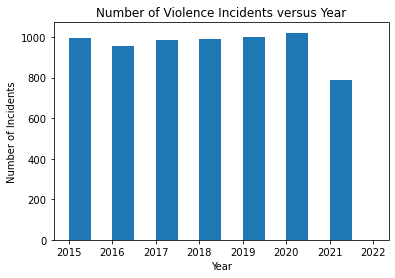

In [7]:
# generate a plot that demonstrates the number of shooting incidents per year
dates = police_data.date
dates_preprocessed = []

# preprocess the date data to extract the years
for i in dates: 
    i_split = i.split("-")
    dates_preprocessed.append(int(i_split[0]))
    
# create a histogram that shows the number of shootings in each year
plt.hist(dates_preprocessed, width = 0.5, bins = range(2015, 2023))
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.title("Number of Violence Incidents versus Year");

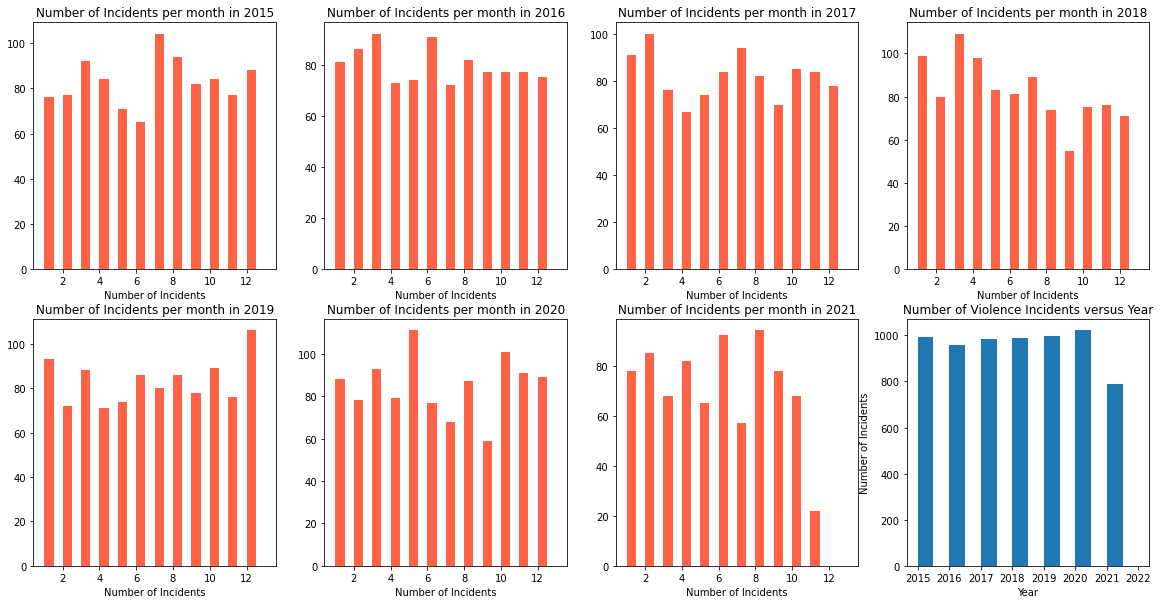

In [8]:
# create separate plots to "zoom into" the crimes committed per year to better understand the timing of crimes in a year

# preprocess the dates to extract the month per year
dates_processed = {}
for i in dates:
    splits = i.split('-')
    if int(splits[0]) not in dates_processed:
        dates_processed[int(splits[0])] = [int(splits[1])]
    else:
        dates_processed[int(splits[0])].append(int(splits[1]))

# plot all the incidents that happen per month per year
F, ax = plt.subplots(2,4, figsize = (20, 10))
for i, year in enumerate(dates_processed):
    ax[i//4, i%4].hist(dates_processed[year], color = 'tomato', width = 0.5, bins = range(1, 14))
    ax[i//4, i%4].set_xlabel("Month")
    ax[i//4, i%4].set_xlabel("Number of Incidents")
    ax[i//4, i%4].set_title("Number of Incidents per month in " + str(year))
    
# add in the plot from the previous cell for comparison
ax[1,3].hist(dates_preprocessed, width = 0.5, bins = range(2015, 2023))
ax[1,3].set_xlabel("Year")
ax[1,3].set_ylabel("Number of Incidents")
ax[1,3].set_title("Number of Violence Incidents versus Year");

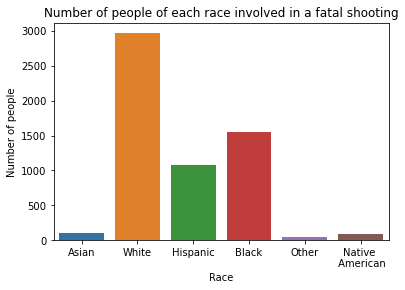

In [9]:
# create a histogram that shows the number of each type of race involved in the incidents
races = police_data.race
F, ax = plt.subplots()
sns.countplot(x = races, ax = ax);
ax.set_xlabel("Race")
ax.set_ylabel("Number of people")
ax.set_title("Number of people of each race involved in a fatal shooting")
ax.set_xticklabels(['Asian', 'White', 'Hispanic', 'Black', 'Other', 'Native \n American']);

### Exploratory data analysis on merged census and FBI data

The proportion of fatal samples among all samples is 0.2864


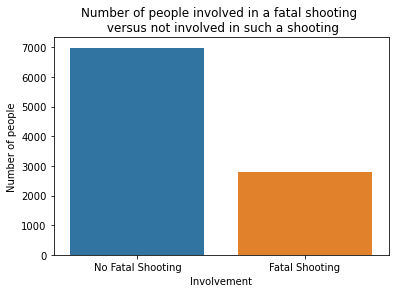

In [10]:
# create a histogram that shows the number of each type of race involved in the incidents
F, ax = plt.subplots()
sns.countplot(x = census_data.fatal, ax = ax);
ax.set_xlabel("Involvement")
ax.set_ylabel("Number of people")
ax.set_title("Number of people involved in a fatal shooting \n versus not involved in such a shooting")
ax.set_xticklabels(['No Fatal Shooting', 'Fatal Shooting']);
print(f'The proportion of fatal samples among all samples is {(census_data.fatal==1).sum()/census_data.shape[0]:.4f}')

In [11]:
# extract the full column names to replace the abbreviated values
columns = pd.DataFrame(census_data.columns.values, columns=['Short_Name'])
col_names = pd.read_csv('columns.csv', index_col = 0)
col_names = pd.merge(columns, col_names, on = ['Short_Name'])
col_names = col_names.set_index(keys = ['Short_Name']).iloc[:,0]
# select a few areas of interest to examine further
zipcodes_fatal = [94124, 76116, 37766]
zipcodes_no_fatal = [94121, 94128, 94130, 76110, 76112, 76120, 37760, 37762, 37769]

In [12]:
# plot male and female age distributions together
def plot_by_age(data, row, ax):
    # extract male statistics
    male_stats = data.loc[row, 'B01001e3':'B01001e25'].values
    male_total = data.loc[row, 'B01001e2']
    male_stats = male_stats / male_total
    
    # extract female statistics
    female_stats = data.loc[row, 'B01001e27':'B01001e49'].values
    female_total = data.loc[row, 'B01001e26']
    female_stats = female_stats / female_total
    
    # set up the x axis tick labels for easier viewing
    ticks = [0, 5, 9, 14, 17, 19, 20, 21, 24, 29, 34, 39, 44, 
               49, 54, 59, 61, 64, 66, 74, 79, 84, 85]
    ticklabels = [ str(i) for i in ticks ]
    num_bins = len(ticks)
    width = 4
    locs = np.arange(num_bins)*width
    
    # plot the bar plot
    ax.bar(locs, male_stats, width = width/2, align = 'edge', label = 'Male')
    ax.bar(locs+width/2, female_stats, width = width/2, align = 'edge', label = 'Female')
    ax.set_ylabel('Ratio') ;
    ax.set_xticks(locs);
    ax.set_xticklabels(ticklabels);
    ax.set_xlabel('Ages')
    ax.legend(loc = 'upper right')

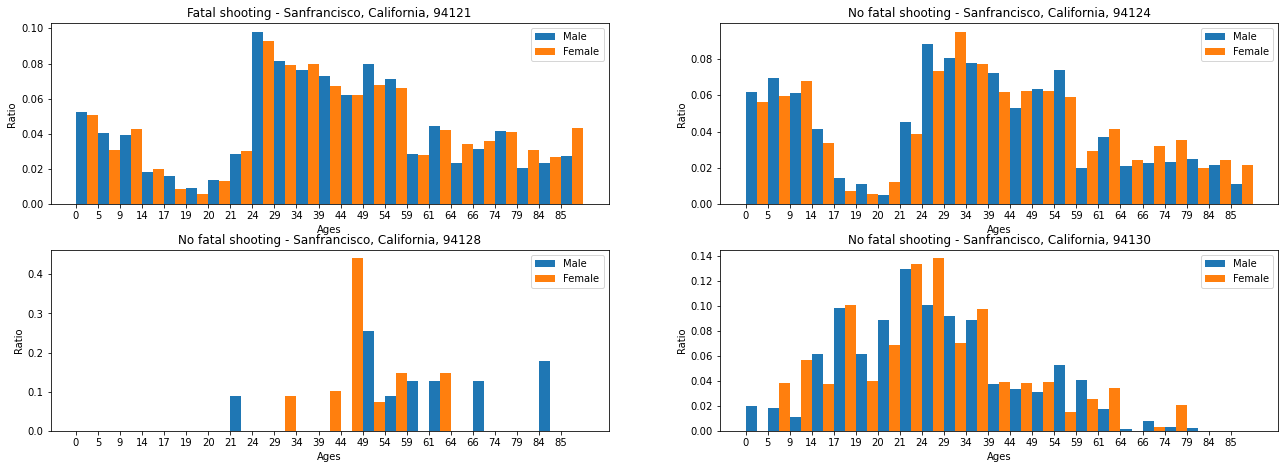

In [13]:
# plot male and female distributions for zipcodes of interest
zipcodes = zipcodes_fatal[:1]+zipcodes_no_fatal[:3]
rows = census_data[census_data.ZCTA5CE10.isin(zipcodes)].index.to_list()
znames = [ census_data.loc[row, 'city'].capitalize()+', '+census_data.loc[row, 'state_name'].capitalize()+', '+ str(census_data.loc[row, 'ZCTA5CE10']) for row in rows]
f, ax = plt.subplots(2, 2, figsize = (22, 7.5), gridspec_kw = dict(hspace=0.25))

# make a plot for each zip code of interest
for i in range(4):
    plot_by_age(census_data, rows[i], ax[i//2, i%2])
    ax[i//2, i%2].set_title('No fatal shooting'+ ' - '+znames[i])
    
ax[0,0].set_title('Fatal shooting'+ ' - '+znames[0]);  

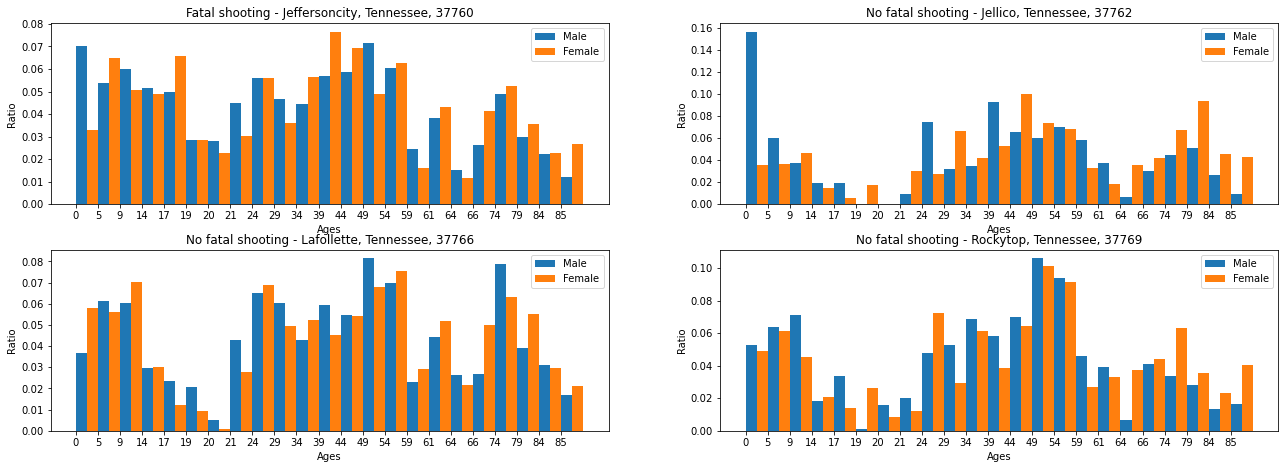

In [14]:
# plot male and female distributions for zipcodes of interest
zipcodes = zipcodes_fatal[2:3]+zipcodes_no_fatal[6:9]
rows = census_data[census_data.ZCTA5CE10.isin(zipcodes)].index.to_list()
znames = [ census_data.loc[row, 'city'].capitalize()+', '+census_data.loc[row, 'state_name'].capitalize()+', '+str(census_data.loc[row, 'ZCTA5CE10']) for row in rows]
f, ax = plt.subplots(2, 2, figsize = (22, 7.5), gridspec_kw = dict(hspace=0.25))

# make a plot for each zip code of interest
for i in range(4):
    plot_by_age(census_data, rows[i], ax[i//2, i%2])
    ax[i//2, i%2].set_title('No fatal shooting'+ ' - '+znames[i])
    
ax[0,0].set_title('Fatal shooting'+ ' - '+znames[0]);  

In [15]:
# create a function to plot race distribution
def plot_race(data, row, ax):
    cols = ['B02001e'+str(i) for i in range(2,11) ]
    cols.pop(6)
    # extract column names
    names1 = col_names[cols[:6]].apply(lambda x: x[13:-38])
    names2 = col_names[cols[6:]].apply(lambda x: x[25:-32])
    names = pd.concat([names1, names2])
    total = data.loc[row, 'B01001e1']
    stats = data.loc[row, cols] / total
    # plot the bar plot
    ax.bar(cols, stats)
    ax.set_ylabel('ratio')
    names[-2] = 'Two races including other race'
    names[-1] = 'Two races and three or more races'
    _ = ax.set_xticklabels(names, rotation = 45, ha = 'right')
    ax.set_xlabel('Race')

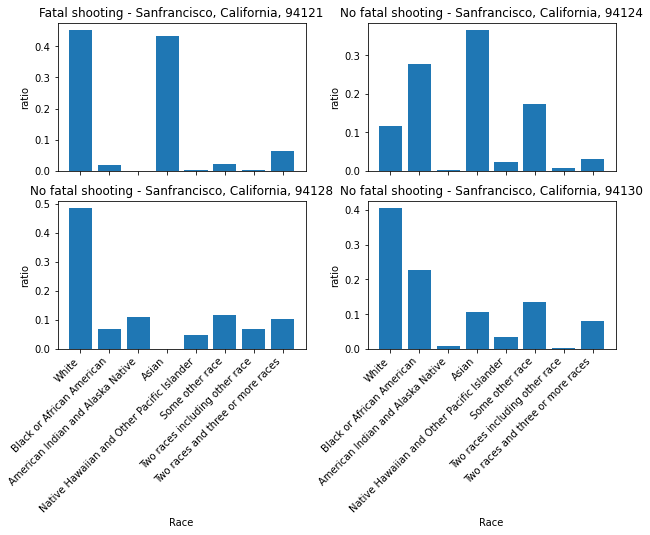

In [16]:
# find race break-down for zipcodes of interest
zipcodes = zipcodes_fatal[:1]+zipcodes_no_fatal[:3]
rows = census_data[census_data.ZCTA5CE10.isin(zipcodes)].index.to_list()
znames = [ census_data.loc[row, 'city'].capitalize()+', '+census_data.loc[row, 'state_name'].capitalize()+', '+str(census_data.loc[row, 'ZCTA5CE10']) for row in rows]
f, ax = plt.subplots(2, 2, figsize = (10, 6), gridspec_kw=dict(wspace=0.25))

# make a plot for each zip code of interest
for i in range(4):
    plot_race(census_data, rows[i], ax[i//2, i%2])
    ax[i//2, i%2].set_title('No fatal shooting'+ ' - '+znames[i])
ax[0,0].set_title('Fatal shooting'+ ' - '+znames[0])
ax[0,0].set_xlabel('');ax[0,1].set_xlabel('');
ax[0,0].set_xticklabels([]);ax[0,1].set_xticklabels([]);

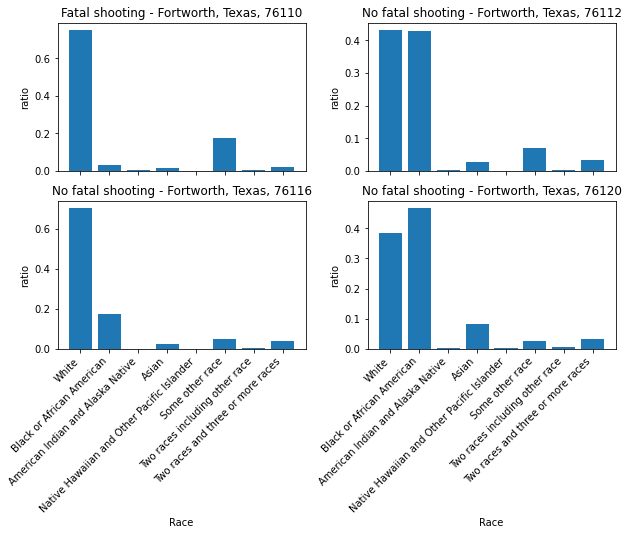

In [17]:
# find race break-down for zipcodes of interest

zipcodes = zipcodes_fatal[1:2]+zipcodes_no_fatal[3:6]
rows = census_data[census_data.ZCTA5CE10.isin(zipcodes)].index.to_list()
znames = [ census_data.loc[row, 'city'].capitalize()+', '+census_data.loc[row, 'state_name'].capitalize()+', '+str(census_data.loc[row, 'ZCTA5CE10']) for row in rows]
f, ax = plt.subplots(2, 2, figsize = (10, 6), gridspec_kw=dict(wspace=0.25))

# make a plot for each zip code of interest
for i in range(4):
    plot_race(census_data, rows[i], ax[i//2, i%2])
    ax[i//2, i%2].set_title('No fatal shooting'+ ' - '+znames[i])
ax[0,0].set_title('Fatal shooting'+ ' - '+znames[0])
ax[0,0].set_xlabel('');ax[0,1].set_xlabel('');
ax[0,0].set_xticklabels([]);ax[0,1].set_xticklabels([]);

In [18]:
# create a function to plot the sex by marital status of samples
def plot_by_marital_status(data, row, ax):
    
    male_total = data.loc[row, 'B12001e2']
    male_cols = ['B12001e'+str(i) for i in range(3, 11)]
    female_total = data.loc[row, 'B12001e11']
    female_cols = ['B12001e'+str(i) for i in range(12, 20)]
        
    female_cols.pop(1)
    female_cols.pop(2)
    male_cols.pop(1)
    male_cols.pop(2)
    
    names = []
    names.append(col_names[male_cols][0][66:-44])
    names.append(col_names[male_cols][1][82:-44])
    names += (col_names[male_cols][2:].apply(lambda x: x[84:-44]).to_list())
    
    male_stats = data.loc[row, male_cols].values / male_total
    female_stats = data.loc[row, female_cols].values / female_total
    
    x = np.arange(len(names))
    width = 0.35
    ax.bar(x - width/2, male_stats, width, label = 'male')
    ax.bar(x + width/2, female_stats, width, label = 'female')
    ax.set_xticks(x);
    ax.set_xticklabels(names, rotation = 30, ha = 'right');
    ax.set_ylabel('Portion Over 15');
    ax.legend()

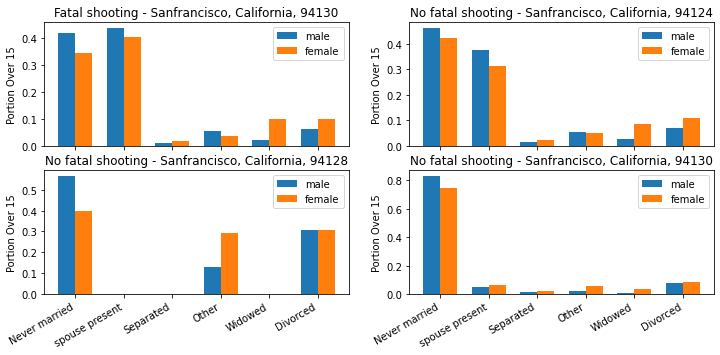

In [19]:
# find marital status break-down for zipcodes of interest
zipcodes = zipcodes_fatal[:1]+zipcodes_no_fatal[:3]
rows = census_data[census_data.ZCTA5CE10.isin(zipcodes)].index.to_list()
znames = [ census_data.loc[row, 'city'].capitalize()+', '+census_data.loc[row, 'state_name'].capitalize()+', '+str(census_data.loc[row, 'ZCTA5CE10']) for row in rows]
f, ax = plt.subplots(2, 2, figsize = (12, 5), gridspec_kw = dict(hspace=0.2))

# make a plot for each zip code of interest
for i in range(4):
    plot_by_marital_status(census_data, rows[i], ax[i//2, i%2])
    ax[i//2, i%2].set_title('No fatal shooting'+' - '+znames[i])
ax[0,0].set_xticklabels([]);ax[0,1].set_xticklabels([]);
ax[0,0].set_title('Fatal shooting'+' - '+znames[i]);    

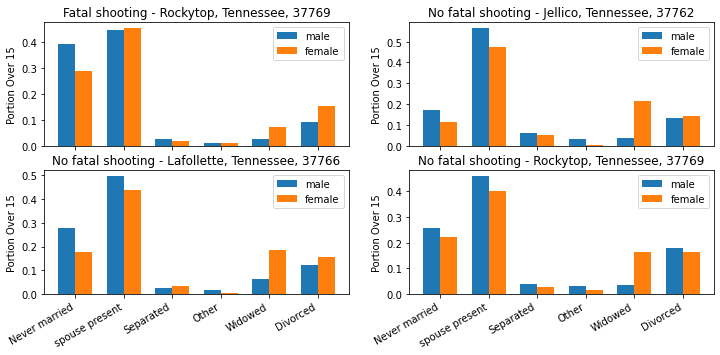

In [20]:
# find marital status break-down for zipcodes of interest
zipcodes = zipcodes_fatal[2:3]+zipcodes_no_fatal[6:9]
rows = census_data[census_data.ZCTA5CE10.isin(zipcodes)].index.to_list()
znames = [ census_data.loc[row, 'city'].capitalize()+', '+census_data.loc[row, 'state_name'].capitalize()+', '+str(census_data.loc[row, 'ZCTA5CE10']) for row in rows]
f, ax = plt.subplots(2, 2, figsize = (12, 5), gridspec_kw = dict(hspace=0.2))

# make a plot for each zip code of interest
for i in range(4):
    plot_by_marital_status(census_data, rows[i], ax[i//2, i%2])
    ax[i//2, i%2].set_title('No fatal shooting'+' - '+znames[i])
ax[0,0].set_xticklabels([]);ax[0,1].set_xticklabels([]);
ax[0,0].set_title('Fatal shooting'+' - '+znames[i]);    

In [21]:
# create a function to plot the sex by marital status of samples
def plot_sex_by_marital_status(data, row, sex, ax):
    if sex in {'m', 'M', 'male'}:
        sex = 'Male'
        total = data.loc[row, 'B12001e2']
        cols = ['B12001e'+str(i) for i in range(3, 11)]
    elif sex in {'f', 'F', 'female'}:
        sex = 'Female'
        total = data.loc[row, 'B12001e11']
        cols = ['B12001e'+str(i) for i in range(12, 20)]
        
    cols.pop(1)
    cols.pop(2)
    names = []
    names.append(col_names[cols][0][66:-44])
    names.append(col_names[cols][1][82:-44])
    names += (col_names[cols][2:].apply(lambda x: x[84:-44]).to_list())
    stats = data.loc[row, cols].values / total
    ax.bar(names, stats)
    _ = ax.set_xticklabels(names, rotation = 30, ha = 'right')
    ax.set_ylabel('Portion Over All ' + sex + ' Over 15')

In [22]:
# function to plot the education level of samples (distribution feature)
def plot_education(data, row, ax):
    total = data.loc[row, 'B15003e1']
    cols = [ 'B15003e'+str(i) for i in range(2, 26)]
    names = col_names[cols].apply(lambda x: x[68:-44]).to_list()
    stats = data.loc[row, cols].values / total
    ax.bar(names, stats)
    ax.set_xticklabels(names, rotation = 45, ha = 'right')
    ax.set_ylabel('Ratio')

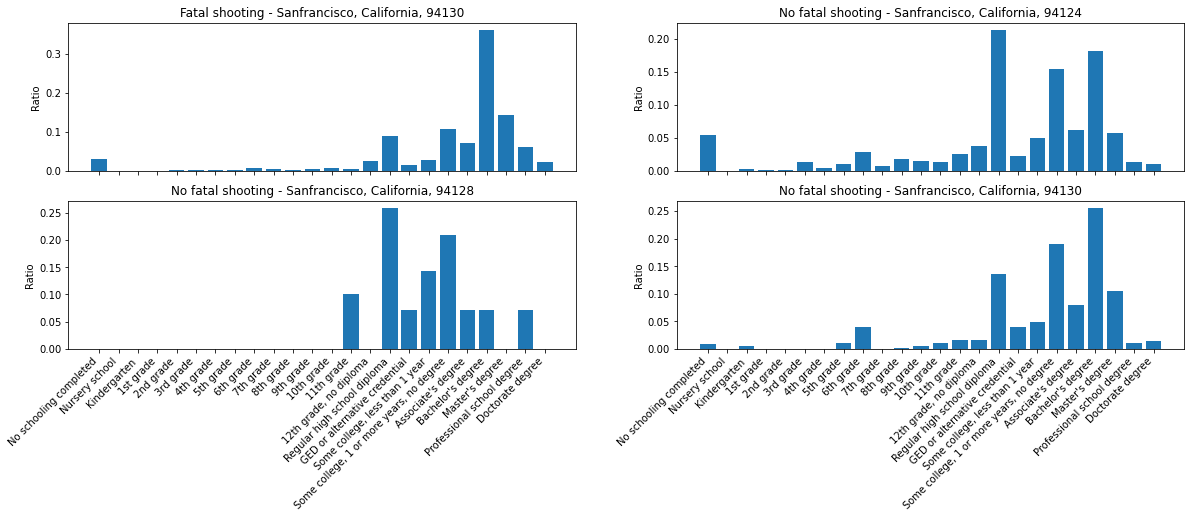

In [23]:
# find education status break-down for zipcodes of interest

zipcodes = zipcodes_fatal[:1]+zipcodes_no_fatal[:3]
rows = census_data[census_data.ZCTA5CE10.isin(zipcodes)].index.to_list()
znames = [ census_data.loc[row, 'city'].capitalize()+', '+census_data.loc[row, 'state_name'].capitalize()+', '+str(census_data.loc[row, 'ZCTA5CE10']) for row in rows]
f, ax = plt.subplots(2, 2, figsize = (20, 6))

# make a plot for each zip code of interest
for i in range(4):
    plot_education(census_data, rows[i], ax[i//2, i%2]);
    ax[i//2, i%2].set_title('No fatal shooting'+' - '+znames[i]);
ax[0,0].set_title('Fatal shooting'+' - '+znames[i]);
ax[0,0].set_xlabel('');ax[0,1].set_xlabel('');
ax[0,0].set_xticklabels([]);ax[0,1].set_xticklabels([]);

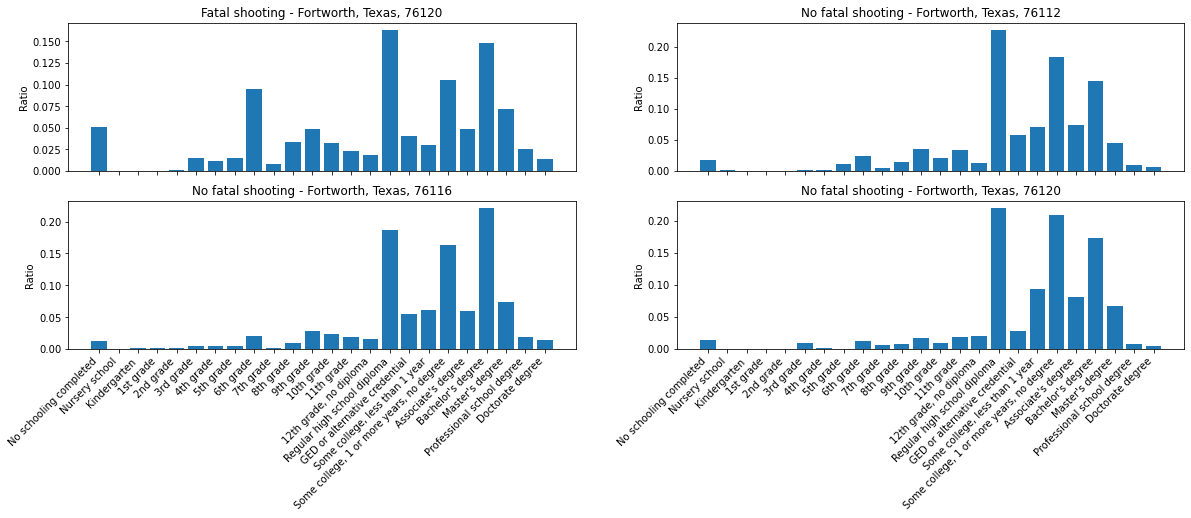

In [24]:
# find education status break-down for zipcodes of interest
zipcodes = zipcodes_fatal[1:2]+zipcodes_no_fatal[3:6]
rows = census_data[census_data.ZCTA5CE10.isin(zipcodes)].index.to_list()
znames = [ census_data.loc[row, 'city'].capitalize()+', '+census_data.loc[row, 'state_name'].capitalize()+', '+str(census_data.loc[row, 'ZCTA5CE10']) for row in rows]
f, ax = plt.subplots(2, 2, figsize = (20, 6))

# make a plot for each zip code of interest
for i in range(4):
    plot_education(census_data, rows[i], ax[i//2, i%2])
    ax[i//2, i%2].set_title('No fatal shooting'+' - '+znames[i])
ax[0,0].set_title('Fatal shooting'+' - '+znames[i])
ax[0,0].set_xlabel('');ax[0,1].set_xlabel('');
ax[0,0].set_xticklabels([]);ax[0,1].set_xticklabels([]);

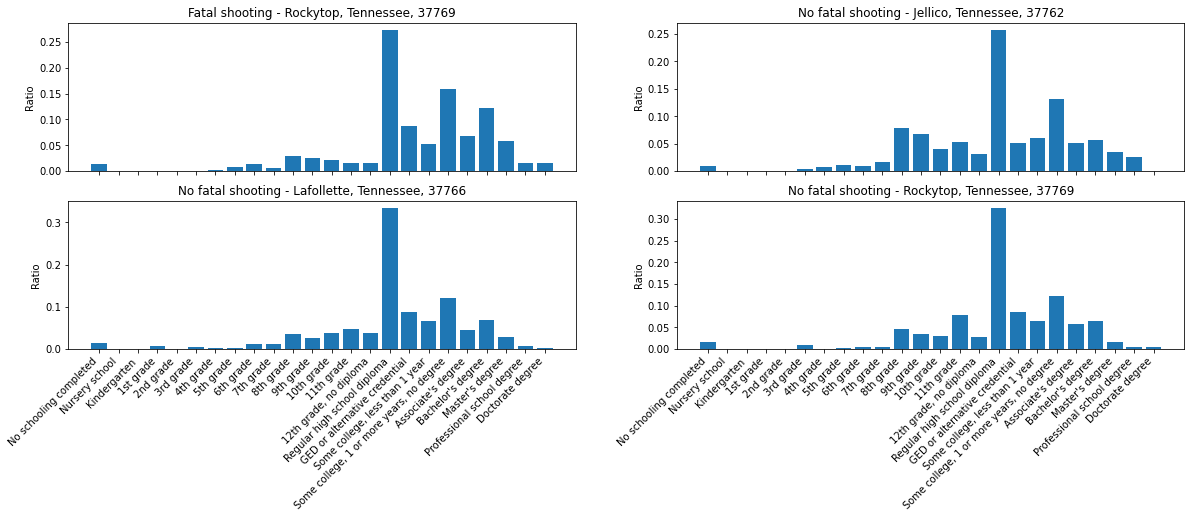

In [25]:
# find education status break-down for zipcodes of interest
zipcodes = zipcodes_fatal[2:3]+zipcodes_no_fatal[6:9]
rows = census_data[census_data.ZCTA5CE10.isin(zipcodes)].index.to_list()
znames = [ census_data.loc[row, 'city'].capitalize()+', '+census_data.loc[row, 'state_name'].capitalize()+', '+str(census_data.loc[row, 'ZCTA5CE10']) for row in rows]
f, ax = plt.subplots(2, 2, figsize = (20, 6))

# make a plot for each zip code of interest
for i in range(4):
    plot_education(census_data, rows[i], ax[i//2, i%2])
    ax[i//2, i%2].set_title('No fatal shooting'+' - '+znames[i])
ax[0,0].set_title('Fatal shooting'+' - '+znames[i])
ax[0,0].set_xlabel('');ax[0,1].set_xlabel('');
ax[0,0].set_xticklabels([]);ax[0,1].set_xticklabels([]);

In [26]:
# function to plot the householding predictor of samples (distribution feature)
def plot_householding(data, row, ax):
    total = data.loc[row, 'B19001e1']
    cols = [ 'B19001e'+str(i) for i in range(2, 17) ]
    names = col_names[cols].apply(lambda x: x[84:-26]).to_list()
    stats = data.loc[row, cols].values / total
    ax.bar(names, stats)
    ax.set_xticklabels(names, rotation = 45, ha = 'right')
    ax.set_ylabel('Ratio')

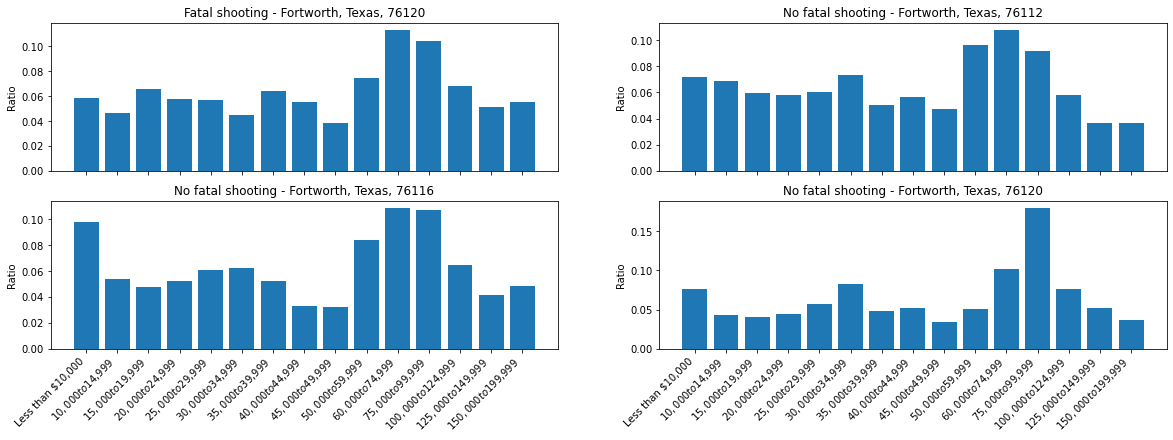

In [27]:
# find householding status break-down for zipcodes of interest
zipcodes = zipcodes_fatal[1:2]+zipcodes_no_fatal[3:6]
rows = census_data[census_data.ZCTA5CE10.isin(zipcodes)].index.to_list()
znames = [ census_data.loc[row, 'city'].capitalize()+', '+census_data.loc[row, 'state_name'].capitalize()+', '+str(census_data.loc[row, 'ZCTA5CE10']) for row in rows]

# make a plot for each zip code of interest
f, ax = plt.subplots(2, 2, figsize = (20, 6))
for i in range(4):
    plot_householding(census_data, rows[i], ax[i//2, i%2])
    ax[i//2, i%2].set_title('No fatal shooting'+' - '+znames[i])
ax[0,0].set_title('Fatal shooting'+' - '+znames[i])
ax[0,0].set_xlabel('');ax[0,1].set_xlabel('');
ax[0,0].set_xticklabels([]);ax[0,1].set_xticklabels([]);

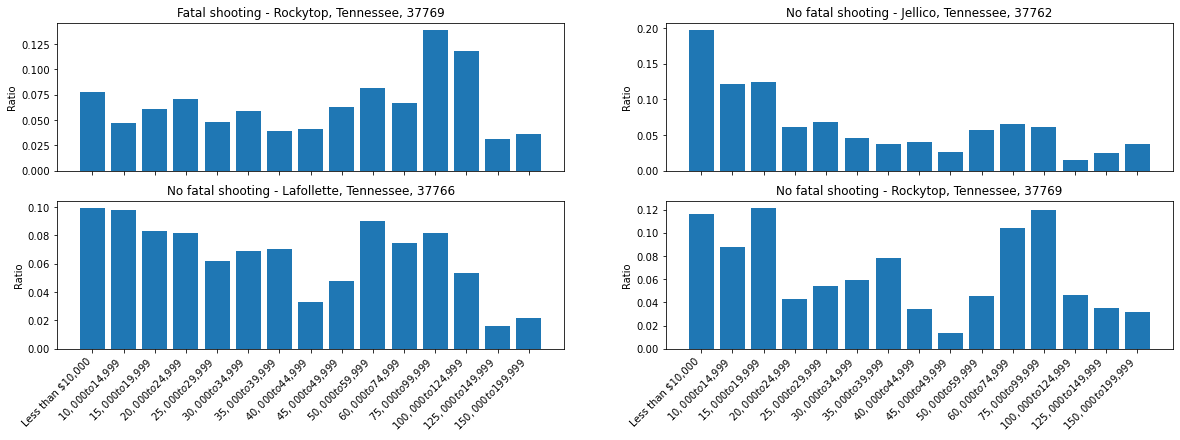

In [28]:
# find householding status break-down for zipcodes of interest
zipcodes = zipcodes_fatal[2:3]+zipcodes_no_fatal[6:9]
rows = census_data[census_data.ZCTA5CE10.isin(zipcodes)].index.to_list()
znames = [ census_data.loc[row, 'city'].capitalize()+', '+census_data.loc[row, 'state_name'].capitalize()+', '+str(census_data.loc[row, 'ZCTA5CE10']) for row in rows]
f, ax = plt.subplots(2, 2, figsize = (20, 6))

# make a plot for each zip code of interest
for i in range(4):
    plot_householding(census_data, rows[i], ax[i//2, i%2])
    ax[i//2, i%2].set_title('No fatal shooting'+' - '+znames[i])
ax[0,0].set_title('Fatal shooting'+' - '+znames[i])
ax[0,0].set_xlabel('');ax[0,1].set_xlabel('');
ax[0,0].set_xticklabels([]);ax[0,1].set_xticklabels([]);

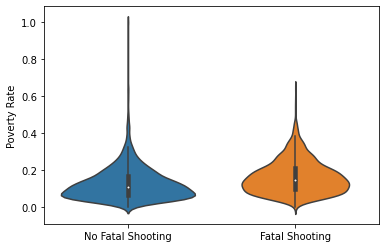

In [29]:
# function to plot the poverty predictor of samples (distribution feature)
def plot_poverty(data, ax): # signle feature
    poverty = data.B17001e2 / data.B17001e1
    sns.violinplot(x = data.fatal, y = poverty, ax = ax)
    ax.set_xticklabels(['No Fatal Shooting', 'Fatal Shooting'])
    ax.set_ylabel('Poverty Rate')
    ax.set_xlabel('')

f, ax = plt.subplots()
plot_poverty(census_data, ax)

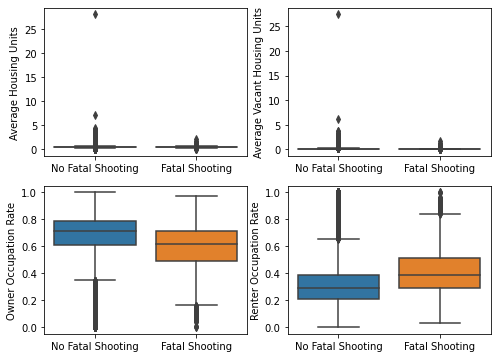

In [30]:
# below we plot four aspects about housings: 1. average housing units per resident, 2. average vacant housing units per resident,
# 3. rented occupation rate: among all the occupied housing units, how much portion is occupied by owners, 4. occupied housing units: among all the occupied housing units, how much portion is occupied by renters
f, ax = plt.subplots(2, 2, figsize = (8,6))
sns.boxplot(x = census_data.fatal, 
               y = (census_data.B25002e1/census_data.B01001e1), ax = ax[0,0])#(census_data.B25002e1/census_data.B01001e1).fillna(0), ax = ax[0, 0])
ax[0, 0].set_xticklabels(['No Fatal Shooting', 'Fatal Shooting'])
ax[0, 0].set_ylabel('Average Housing Units')
sns.boxplot(x = census_data.fatal, y = (census_data.B25002e3/census_data.B01001e1), ax = ax[0, 1])
ax[0, 1].set_xticklabels(['No Fatal Shooting', 'Fatal Shooting'])
ax[0, 1].set_ylabel('Average Vacant Housing Units')
sns.boxplot(x = census_data.fatal, y = (census_data.B25003e2/census_data.B25002e2), ax = ax[1, 0])
ax[1, 0].set_xticklabels(['No Fatal Shooting', 'Fatal Shooting'])
ax[1, 0].set_ylabel('Owner Occupation Rate')
sns.boxplot(x = census_data.fatal, y = (census_data.B25003e3/census_data.B25002e2), ax = ax[1, 1])
ax[1, 1].set_xticklabels(['No Fatal Shooting', 'Fatal Shooting'])
ax[1, 1].set_ylabel('Renter Occupation Rate')
for i in range(4):
    ax[i//2, i%2].set_xlabel('')

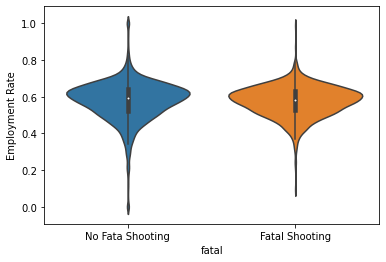

In [31]:
# plot employment statistics
cols = [ 'B01001e'+str(i) for i in range(6, 26) ] + [ 'B01001e'+str(i) for i in range(30, 49) ]
pop_over_16 = census_data[cols].sum(axis = 1)
employment_rate = census_data.B08006e1/pop_over_16
f, ax = plt.subplots()
sns.violinplot(x = census_data.fatal.drop(index = 3109), y = employment_rate.drop(index = 3109), ax = ax)
_ = ax.set_xticklabels(['No Fata Shooting', 'Fatal Shooting'])
_ = ax.set_ylabel('Employment Rate')

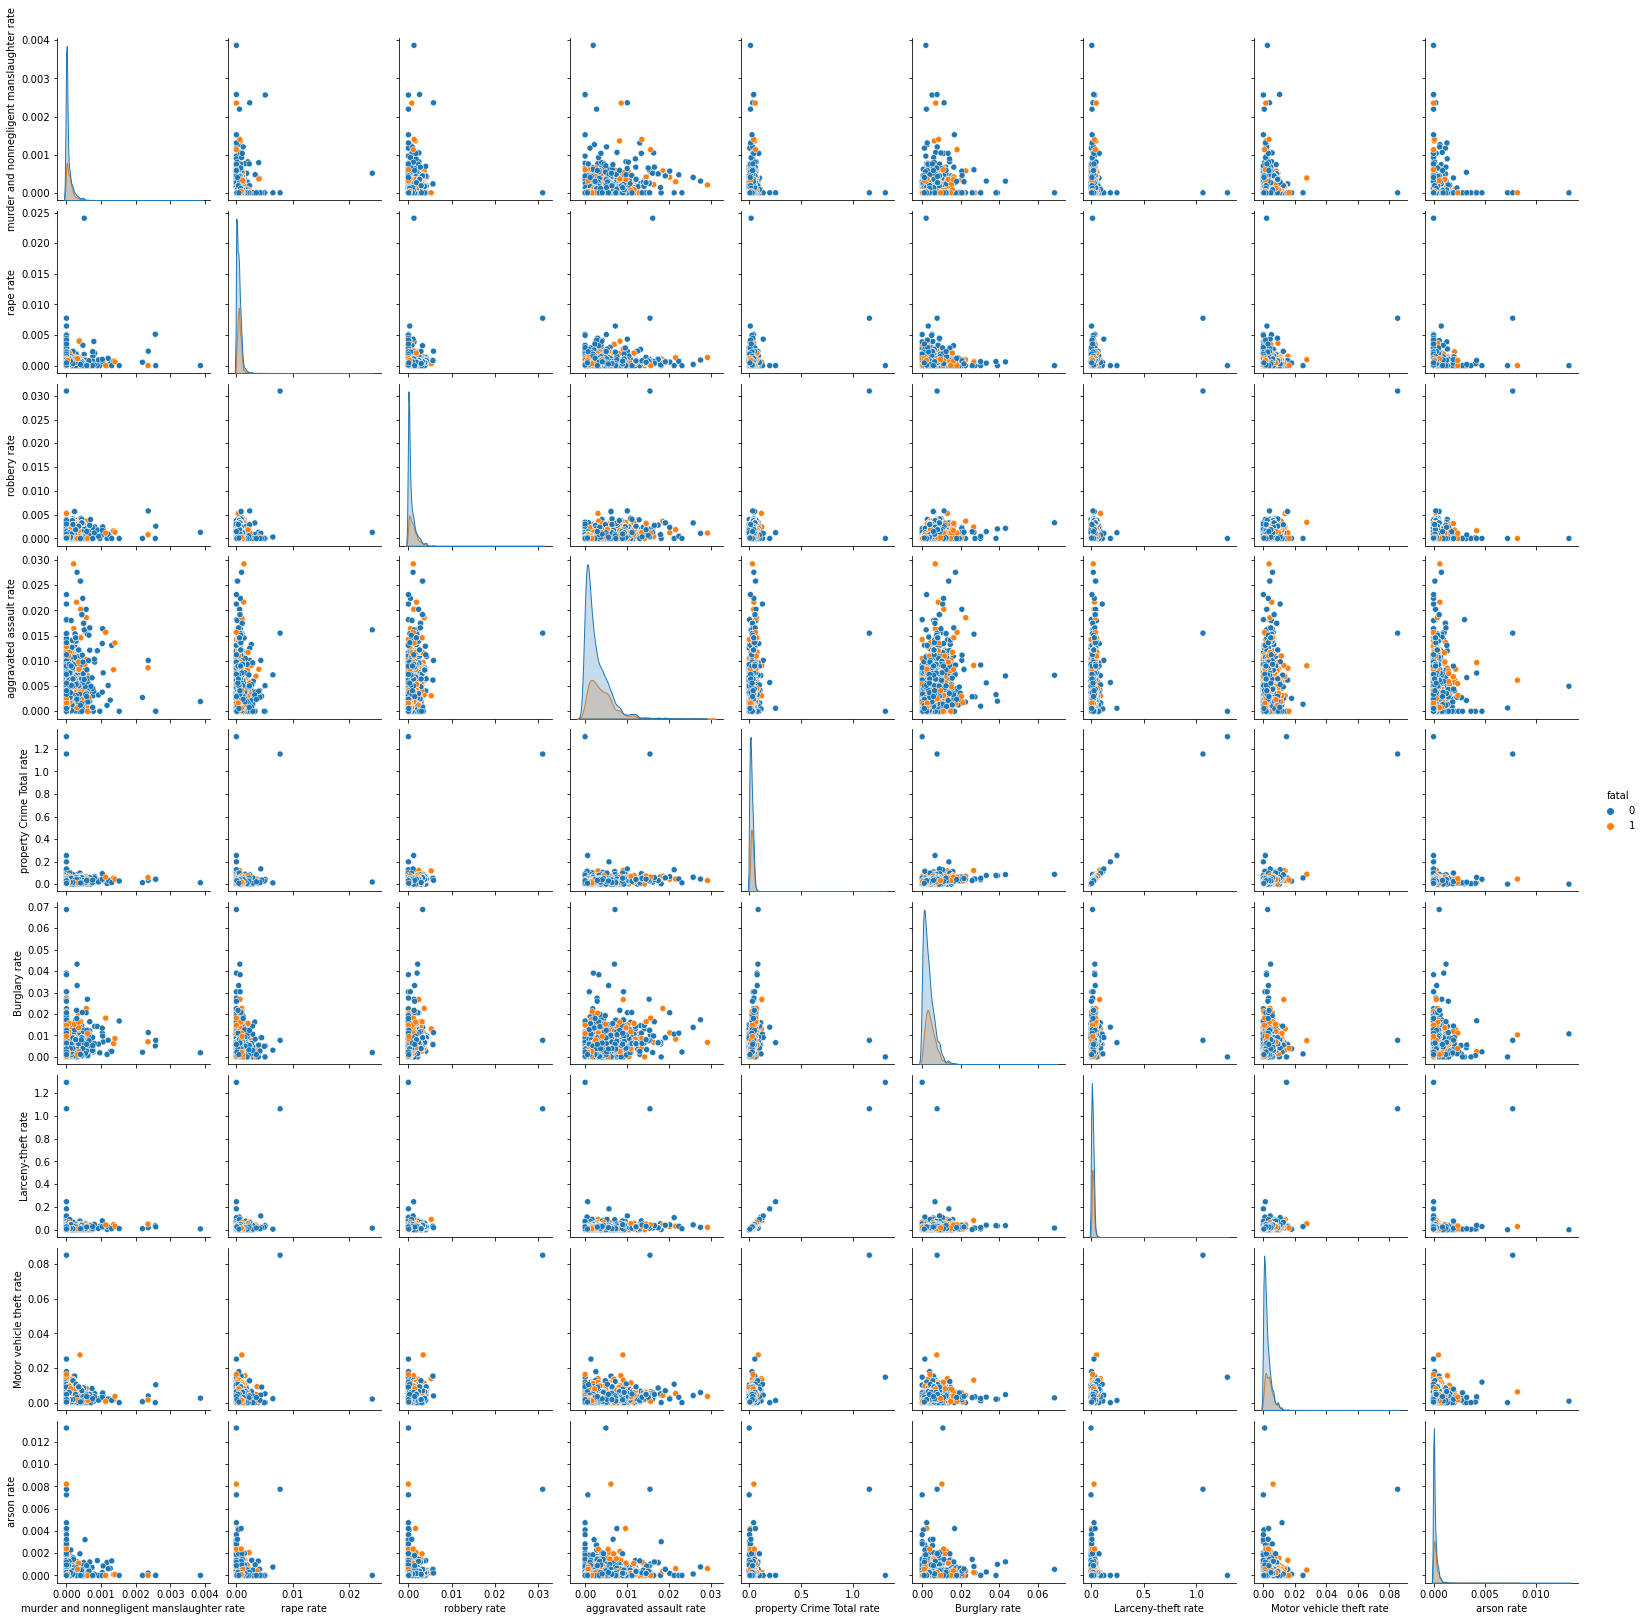

In [32]:
# draw a pair plot to explore the relation between predictors and the response
col_crime_rates = [
     'murder and nonnegligent manslaughter rate',
     'rape rate',
     'robbery rate',
     'aggravated assault rate',
     'property Crime Total rate',
     'Burglary rate',
     'Larceny-theft rate',
     'Motor vehicle theft rate',
     'arson rate',
     'fatal'
]

sns.pairplot(data = census_data[col_crime_rates], hue = 'fatal')

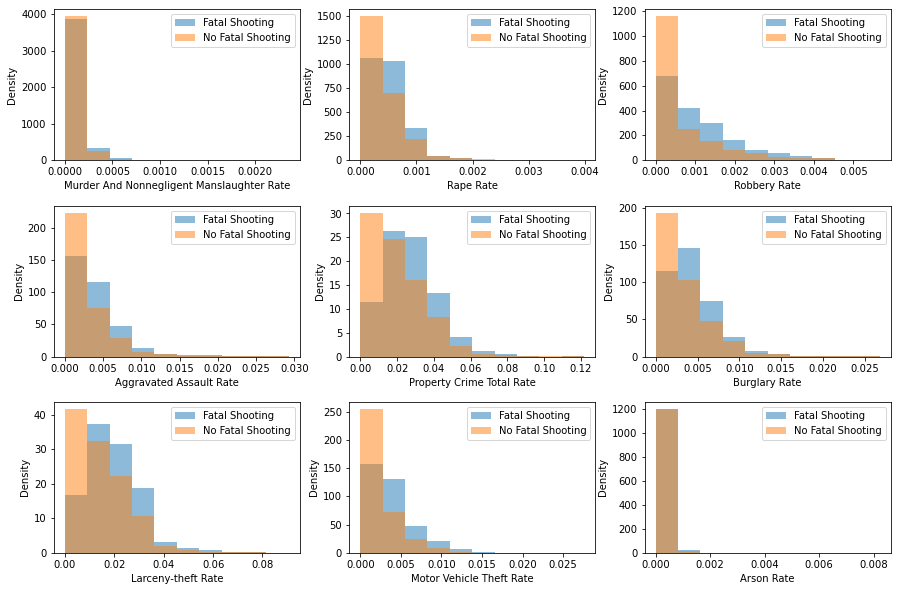

In [33]:
# plot the various crime rates and their relationships with fatal police shootings
f, ax = plt.subplots(3, 3, figsize = (15, 10), gridspec_kw=dict(hspace=0.3))
for i in range(9):
    _, bins, _ = ax[i//3,i%3].hist(census_data.loc[census_data.fatal==1,col_crime_rates[i]], 
                                   alpha = 0.5, label = 'Fatal Shooting', density=True)
    ax[i//3,i%3].hist(census_data.loc[census_data.fatal==0,col_crime_rates[i]], 
                      alpha = 0.5, label = 'No Fatal Shooting', density=True,
                     bins = bins)
    names = ' '.join(map(lambda x: x.capitalize(),col_crime_rates[i].split(' ')))
    ax[i//3, i%3].set_xlabel(names)
    ax[i//3, i%3].set_ylabel('Density')
    ax[i//3, i%3].legend()

# Census data and fatal shooting only modeling

Here we create a hypertuned logistic regression model on the merged census data and the fatal shooting data.

### Data cleaning and preparation for modeling

In [34]:
# read in the merged census data
# this file contains census data at the zip code level along with counts of fatal shootings
shootings = pd.read_csv("census_merged.csv")

print("Number of data samples:", shootings.shape[0])
print("Number of columns:", shootings.shape[1])

shootings = shootings.loc[(shootings.B01001e1 != 0), :]
shootings['fatal'] = np.where(shootings['counts']>0, 1, 0)

display(shootings.head())

# read in the column names (long column descriptions)
col_names = pd.read_csv('columns.csv', index_col = 0)
short_columns = col_names['Short_Name'].values

Number of data samples: 33120
Number of columns: 182


,ZCTA5CE10,Shape_Area,B01001e1,B01001e2,B01001e3,B01001e4,B01001e5,B01001e6,B01001e7,B01001e8,...,B28001e4,B28001e5,B28001e6,B28001e7,B28001e8,B28001e9,B28001e10,B28001e11,counts,fatal
0,43451,0.006843,1246,684,37,53,14,42,5,19,...,29,369,27,272,2,1,0,32,0,0
1,43452,0.014587,13757,6481,180,409,499,212,109,45,...,679,4605,317,3655,47,241,20,679,0,0
2,43456,0.001116,399,214,8,0,8,4,0,0,...,7,143,7,113,0,9,0,10,0,0
3,43457,0.005158,1490,770,28,49,79,47,11,14,...,25,396,13,359,22,2,0,94,0,0
4,43458,0.000282,385,202,12,2,20,8,12,0,...,20,129,30,75,0,2,0,12,0,0


In [35]:
response = "fatal"
irrelevant_predictors = ['counts', 'ZCTA5CE10']

shootings_zip = shootings['ZCTA5CE10']

# drop all irrelevant predictors and the response variable from the X data
shootings = shootings.drop(irrelevant_predictors, axis = 1)

# now we scale all of the census data variables by the total population
# this gives us a more consistent set of predictors
# since the crime data is in rates rather than counts

total_population_column = 'B01001e1'
cols = [col for col in shootings.columns.values if col in short_columns and col!=total_population_column]
shootings.loc[:, cols] = shootings.loc[:, cols].div(shootings[total_population_column], axis=0)

train_data, test_data = train_test_split(shootings, test_size=0.20, random_state=42) 

# then create the training feature set (X_train) and the response vector (y_train)
X_train, y_train = train_data.drop(response, axis=1), train_data[response]
X_test, y_test = test_data.drop(response, axis=1), test_data[response]
print("Train data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

Train data shape:  (26220, 180) (26220,)
Test data shape:  (6556, 180) (6556,)


Train Logistic Accuracy:  0.8791
Test Logistic Accuracy:  0.8783
Best C value:  0.0464


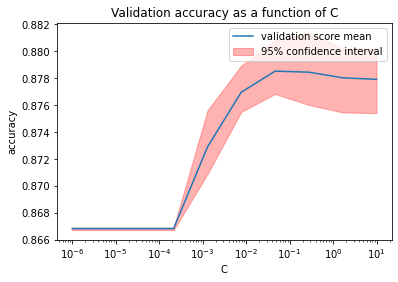

In [36]:
# to create a baseline model, use all numeric features and drop the non-numeric features 
X_train_numeric = X_train._get_numeric_data()
X_test_numeric = X_test._get_numeric_data()

# standardize the data 
standard_scaler = StandardScaler()
standard_scaler.fit(X_train_numeric)
X_train_numeric_scaled = standard_scaler.transform(X_train_numeric)
X_test_numeric_scaled = standard_scaler.transform(X_test_numeric)

def perform_logistic_regression_with_cross_validation(c_vals):

    # create a logistic regression model
    clf = LogisticRegressionCV(Cs = c_vals, penalty = 'l1', cv=5, solver = 'liblinear', max_iter = 100, random_state = 209)
    
    # fit the model and tune the hyperparameter
    clf.fit(X_train_numeric_scaled, y_train)
    print(f"Train Logistic Accuracy: {clf.score(X_train_numeric_scaled, y_train): .4f}")
    print(f"Test Logistic Accuracy: {clf.score(X_test_numeric_scaled, y_test): .4f}")
    print(f"Best C value: {clf.C_[0]: .4f}")
    return clf

# create a set of penalties to loop over
c_vals = np.logspace(-6, 1, 10)

clf = perform_logistic_regression_with_cross_validation(c_vals)
cross_scores = np.array(clf.scores_[1])
validation_scores = np.mean(cross_scores, axis=0)
percentiles = np.percentile(cross_scores, [2.5, 97.5], axis = 0)

plt.plot(c_vals, validation_scores, label='validation score mean')
plt.fill_between(c_vals, percentiles[0], percentiles[1], alpha = 0.3, color = 'r', label = '95% confidence interval')
plt.gca().set_xscale('log')
plt.legend()
plt.title('Validation accuracy as a function of C')
plt.xlabel('C')
plt.ylabel('accuracy');

In [37]:
pd.set_option('display.max_colwidth', None)

coefficients = pd.DataFrame({'columns':X_train_numeric.columns.values, 'coefficient':clf.coef_[0]})
coefficients_top = coefficients.sort_values('coefficient', ascending=False)[:9]
coefficients_top = coefficients_top.merge(col_names, left_on = 'columns', right_on = 'Short_Name')
coefficients_top.drop(columns = ['columns', 'Short_Name'], inplace=True)
display(coefficients_top);

,coefficient,Full_Name
0,0.900497,SEX BY AGE: Total: Total population -- (Estimate)
1,0.220540,TYPES OF COMPUTERS IN HOUSEHOLD: Has one or more types of computing devices: Smartphone: Households -- (Estimate)
2,0.123666,RACE: Total: Black or African American alone: Total population -- (Estimate)
3,0.123037,POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE: Total: Population for whom poverty status is determined -- (Estimate)
4,0.119308,"SEX BY MARITAL STATUS FOR THE POPULATION 15 YEARS AND OVER: Married, spouse absent: Divorced: Population 15 years and over -- (Estimate)"
5,0.098140,TRAVEL TIME TO WORK: Total: 10 to 14 minutes: Workers 16 years and over who did not work from home -- (Estimate)
6,0.095266,"EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Total: Some college, 1 or more years, no degree: Population 25 years and over -- (Estimate)"
7,0.080787,"EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Total: Some college, less than 1 year: Population 25 years and over -- (Estimate)"
8,0.075913,"EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Total: 12th grade, no diploma: Population 25 years and over -- (Estimate)"


In [38]:
predictors = shootings.drop(response, axis=1)
predictors_numeric = predictors._get_numeric_data()

# standardize the data 
X_all = standard_scaler.transform(predictors_numeric)

probabilities = clf.predict_proba(X_all)[:, 1]

risks = shootings_zip.to_frame()
risks.loc[:, 'risk score'] = probabilities
display(risks.head(15))

,ZCTA5CE10,risk score
0,43451,0.046285
1,43452,0.103732
2,43456,0.008246
3,43457,0.035486
4,43458,0.040829
5,43460,0.093003
6,43462,0.051962
7,43463,0.165732
8,43464,0.033420
9,43465,0.086815


We perform a spatial join on zip code tabulations to create a nice map of our risk scores.

![ZCTA fatal shooting risk score for CONUS](census_only_map.png)

## Census and FBI data modeling

Now that we created risk scores for the entire US, we analyze the merged census data, FBI crime data, and the fatal shooting data for the subset of the US that this data is available for.

In [39]:
response = "fatal"
irrelevant_predictors = ['lat', 'lng', 'counts', 'ZCTA5CE10', 'INTPTLAT10', 'INTPTLON10', 
                         'Shape_Leng', 'GEOID10', 'GEOID_Data', 'GEOID', 'FUNCSTAT10', 'MTFCC10', 'CLASSFP10' ]

# drop all irrelevant predictors and the response variable from the X data
census_data = census_data.drop(irrelevant_predictors, axis = 1)

# scale all of the census data variables by the total population
# this gives us a more consistent set of predictors since the crime data is in rates rather than counts
total_population_column = 'B01001e1'
cols = [col for col in census_data.columns.values if col in short_columns and col!=total_population_column]
census_data.loc[:, cols] = census_data.loc[:, cols].div(census_data[total_population_column], axis=0)

train_data, test_data = train_test_split(census_data, test_size=0.20, random_state=42) 

# create the training feature set (X_train) and the response vector (y_train)
X_train, y_train = train_data.drop(response, axis=1), train_data[response]
X_test, y_test = test_data.drop(response, axis=1), test_data[response]
print("Train data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

Train data shape:  (7833, 196) (7833,)
Test data shape:  (1959, 196) (1959,)


In [40]:
# view the newly scaled data
census_data.head()

,Shape_Area,city,state_name,county_name,city population,violent Crime Rate,murder and nonnegligent manslaughter rate,rape rate,robbery rate,aggravated assault rate,...,B28001e3,B28001e4,B28001e5,B28001e6,B28001e7,B28001e8,B28001e9,B28001e10,B28001e11,fatal
0,0.014587,portclinton,ohio,Ottawa,6159,0.002111,0.000000,0.001786,0.000000,0.000325,...,0.366141,0.049357,0.334739,0.023043,0.265683,0.003416,0.017518,0.001454,0.049357,0
1,0.220313,enterprise,oregon,Wallowa,2002,0.001499,0.000000,0.000999,0.000000,0.000500,...,0.343137,0.050917,0.320683,0.032258,0.221063,0.001581,0.004428,0.000000,0.061037,0
2,0.052616,hermiston,oregon,Umatilla,17896,0.002068,0.000056,0.000391,0.000447,0.001173,...,0.254464,0.029977,0.278094,0.028027,0.207242,0.002218,0.008718,0.000000,0.033916,0
3,0.086089,lagrande,oregon,Union,13674,0.001463,0.000000,0.000073,0.000073,0.001316,...,0.310628,0.034174,0.316121,0.026772,0.233260,0.002544,0.011391,0.000636,0.040997,0
4,0.131688,pilotrock,oregon,Umatilla,1510,0.003974,0.000000,0.000662,0.000000,0.003311,...,0.298147,0.032566,0.304323,0.029759,0.185851,0.000000,0.020213,0.000000,0.052218,0


![Census and Crime data zip code analysis](main_map.png)

### Baseline logistic regression using all predictors and using no penalty

Here are we don't perform any upsampling of the data, so the dataset is very imbalanced.  For this reason, we get a high accuracy, but a very poor false negative rate.  The model is simply predicting that most ZCTAs don't have a fatal shooting, which is true.

In [41]:
# to create a baseline model, use all numeric features and drop the non-numeric features 
X_train_numeric = X_train._get_numeric_data()
X_test_numeric = X_test._get_numeric_data()

# standardize the data 
standard_scaler = StandardScaler()
standard_scaler.fit(X_train_numeric)
X_train_numeric_scaled = standard_scaler.transform(X_train_numeric)
X_test_numeric_scaled = standard_scaler.transform(X_test_numeric)

# build a simple logistic regression model which uses all of the numeric features
lreg = LogisticRegression(max_iter = 2000, solver = 'liblinear').fit(X_train_numeric_scaled, y_train)
test_accuracy = lreg.score(X_test_numeric_scaled, y_test)
print(f"Train Baseline Accuracy: {lreg.score(X_train_numeric_scaled, y_train): .4f}")
print(f"Test Baseline Accuracy: {test_accuracy: .4f}")

Train Baseline Accuracy:  0.7742
Test Baseline Accuracy:  0.7545


In [42]:
# extract the full column names to replace the abbreviated values
columns = pd.DataFrame(X_train_numeric.columns.values, columns=['Short_Name'])
col_names = pd.merge(columns, col_names, how = 'left',on = ['Short_Name'])
col_names.loc[col_names['Full_Name'].isnull(),'Full_Name'] = col_names.loc[col_names['Full_Name'].isnull(),'Short_Name']
col_names = col_names.set_index(keys = ['Short_Name']).iloc[:,0]

## Derive feature importances

Since we have so many predictors, it is important to select only a subset of these features for modeling.

In [43]:
# run permutation feature importance to extract feature importances
forest_for_selecting = RandomForestClassifier(n_estimators = 100, random_state = 209, max_depth = 15)
forest_for_selecting.fit(X_train_numeric_scaled, y_train)
perm = PermutationImportance(forest_for_selecting, random_state=209, n_iter=10).fit(X_train_numeric_scaled, y_train)

In [44]:
# display all feature importances using eli5 to color-coordinate the features
eli5.explain_weights(perm, feature_names=col_names[X_train_numeric.columns.tolist()].tolist(), top = 50)

Weight,Feature
0.0337 ± 0.0035,SEX BY AGE: Total: Total population -- (Estimate)
0.0052 ± 0.0009,robbery rate
0.0042 ± 0.0009,city population
0.0035 ± 0.0005,Motor vehicle theft rate
0.0031 ± 0.0007,arson rate
0.0027 ± 0.0006,murder and nonnegligent manslaughter rate
0.0023 ± 0.0008,violent Crime Rate
0.0021 ± 0.0006,RACE: Total: American Indian and Alaska Native alone: Total population -- (Estimate)
0.0017 ± 0.0003,RACE: Two or more races: Two races including Some other race: Total population -- (Estimate)
0.0017 ± 0.0005,POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE: Income in the past 12 months below poverty level: Population for whom poverty status is determined -- (Estimate)


## Perform feature selection

We perform feature selection using permutation based feature importances a random forest.  We also use SMOTE to perform upsampling of our data to create a balanced response.

In [88]:
# select a reasonable number of features to use
number_of_features = 40

# extract feature importances
feature_importances = perm.feature_importances_

# find the column names of the important features
important_columns = {}
for key, importance in zip(X_train_numeric.columns.values, feature_importances):
    important_columns[key] = importance

important_columns_df = pd.Series(important_columns).sort_values(ascending = False)
important_columns_df = important_columns_df.iloc[0: number_of_features]

# use SMOTE to resample the training set: perform upsampling using SMOTE

# define a SMOTE with random_state=2
sm = SMOTE(random_state = 2)

# Use the SMOTE object to upsample the train data
X_train_numeric_res, y_train_res = sm.fit_resample(X_train_numeric, y_train)

# select the balanced data from SMOTE
X_train_numeric_selected = X_train_numeric_res.loc[:, important_columns_df.index]
X_test_numeric_selected = X_test_numeric.loc[:, important_columns_df.index]

# scale the feature-selected and balanced data
standard_scaler = StandardScaler()
standard_scaler.fit(X_train_numeric_selected)
X_train_numeric_scaled_selected = standard_scaler.transform(X_train_numeric_selected)
X_test_numeric_scaled_selected = standard_scaler.transform(X_test_numeric_selected)
model_results = dict()

 ### Create a simple logistic regression model with selected features
 
 For our baseline, we perform logistic regression on the upsampled (SMOTE) data without any hyperparameter tuning.

In [46]:
# build a simple logistic regression model which the selected features
lreg = LogisticRegression(max_iter = 1000, solver = 'liblinear').fit(X_train_numeric_scaled_selected, y_train_res)
test_accuracy = lreg.score(X_test_numeric_scaled_selected, y_test)
print(f"Train Baseline Accuracy: {lreg.score(X_train_numeric_scaled_selected, y_train_res): .4f}")
print(f"Test Baseline Accuracy: {test_accuracy: .4f}")

# store the fpr, fnr, and model accuracy for later evalaution
predictions = lreg.predict(X_test_numeric_scaled_selected)
fpr = np.sum((predictions == 1) & (y_test==0)) / np.sum(y_test==0)
fnr = np.sum((predictions == 0) & (y_test==1)) / np.sum(y_test==1)
model_results['logistic_feature_select'] = [test_accuracy, fpr, fnr]

Train Baseline Accuracy:  0.7364
Test Baseline Accuracy:  0.7085


### Tune a logistic regression model using cross validation

Now we perform hyperparameter tuning with logistic regression with L2 penalty (the default) for various values of C

In [47]:
# create a function which performs logistic regression with cross validation on desired data
def perform_logistic_regression_with_cross_validation(c_vals, X_train_numeric_scaled_selected, X_test_numeric_scaled_selected, y_train, y_test):

    # create a logistic regression model
    logit = LogisticRegressionCV(Cs = c_vals, cv=5, solver = 'liblinear', max_iter = 2000, random_state = 209)
    
    # fit the model and tune the hyperparameter
    logit.fit(X_train_numeric_scaled_selected, y_train)
    print(f"Train Logistic Accuracy: {logit.score(X_train_numeric_scaled_selected, y_train): .4f}")
    print(f"Test Logistic Accuracy: {logit.score(X_test_numeric_scaled_selected, y_test): .4f}")
    print(f"Best C value: {logit.C_[0]}")
    
    return logit


Train Logistic Accuracy:  0.7372
Test Logistic Accuracy:  0.7095
Best C value: 100.0


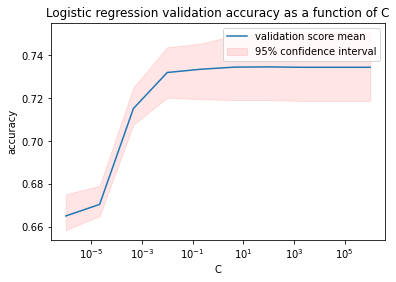

In [48]:
# Plot the logistic regression model results 

# create a set of penalties to loop over
c_vals = np.logspace(-6, 6, 10)
# perform logistic regression with cross validation
logit = perform_logistic_regression_with_cross_validation(c_vals, X_train_numeric_scaled_selected, 
                                                        X_test_numeric_scaled_selected, y_train_res, y_test)
# extract cross validated scores
cross_scores = np.array(logit.scores_[1])
validation_scores = np.mean(cross_scores, axis=0)
# extract percentiles for plotting
percentiles = np.percentile(cross_scores, [2.5, 97.5], axis = 0)

# plot the accuracy and confidence intervals for logistic regression
test_accuracy = logit.score(X_test_numeric_scaled_selected, y_test)
predictions = logit.predict(X_test_numeric_scaled_selected)

# store the fpr, fnr, and model accuracy for later evalaution
fpr = np.sum((predictions == 1) & (y_test==0)) / np.sum(y_test==0)
fnr = np.sum((predictions == 0) & (y_test==1)) / np.sum(y_test==1)
model_results['logistic_cv'] = [test_accuracy, fpr, fnr]

plt.plot(c_vals, validation_scores, label='validation score mean')
plt.fill_between(c_vals, percentiles[0], percentiles[1], alpha = 0.1, color = 'r', label = '95% confidence interval')
plt.gca().set_xscale('log')
plt.legend()
plt.title('Logistic regression validation accuracy as a function of C')
plt.xlabel('C')
plt.ylabel('accuracy');

### Create a random forest model with selected features

Now we perform hyperparameter tuning of the depth in a random forest model.  We see that this model performs very well on our dataset.

In [49]:
# create a function which creates a random forest with cross validation on desired data
def perform_random_forest_with_cross_validation(depths, X_train_numeric_scaled_select, X_test_numeric_scaled_selected, 
                                                y_train, y_test):

    cvmeans, cvlower, cvupper  = [], [], []

    # iterate over all depths to fit a decision tree with
    for depth in depths: 
        # create and fit a random forest tree classifier
        rf_classifier = RandomForestClassifier(n_estimators = 30, max_depth = depth, max_features = "sqrt")
        # perform 5-fold cross-validation with the entire training set
        cv_res = cross_val_score(rf_classifier, X_train_numeric_scaled_selected, y_train, cv=10)
        cvmeans.append(np.mean(cv_res))
        cvlower.append(np.percentile(cv_res, 2.5))
        cvupper.append(np.percentile(cv_res, 97.5))

    max_cv_score = max(cvmeans)
    best_depth = cvmeans.index(max_cv_score) + 1

    # refit the random forest classifier on all training data before final run
    rf_classifier = RandomForestClassifier(n_estimators = 30, max_depth = best_depth, max_features = "sqrt")
    rf_classifier.fit(X_train_numeric_scaled_selected, y_train)
    random_forest_train_score = rf_classifier.score(X_train_numeric_scaled_selected, y_train)
    random_forest_test_score = rf_classifier.score(X_test_numeric_scaled_selected, y_test)
    print(f"Random Forest Classifier Train Accuracy: {random_forest_train_score: .4f}")
    print(f"Random Forest Classifier Test Accuracy: {random_forest_test_score: .4f}")
    print(f"Best Depth {best_depth}")
    
    return cvmeans, cvlower, cvupper, rf_classifier


Random Forest Classifier Train Accuracy:  0.9972
Random Forest Classifier Test Accuracy:  0.7223
Best Depth 27


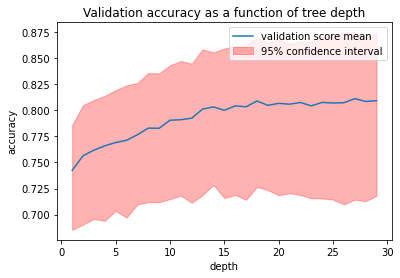

In [50]:
# Plot the random forest model results 

# create a set of depths to loop over
depths = range(1, 30)
# run the random forest classifier with cross validation
cvmeans, cvlower, cvupper, random_forest = perform_random_forest_with_cross_validation(depths,
                        X_train_numeric_scaled_selected, X_test_numeric_scaled_selected, y_train_res, y_test)


# find the accuracy and confidence intervals for logistic regression
test_accuracy = random_forest.score(X_test_numeric_scaled_selected, y_test)
predictions = random_forest.predict(X_test_numeric_scaled_selected)

# store the fpr, fnr, and model accuracy for later evalaution
fpr = np.sum((predictions == 1) & (y_test==0)) / np.sum(y_test==0)
fnr = np.sum((predictions == 0) & (y_test==1)) / np.sum(y_test==1)
model_results['random_forest_cv'] = [test_accuracy, fpr, fnr]

# plot the accuracy and confidence intervals for logistic regression
plt.plot(depths, cvmeans, label='validation score mean')
plt.fill_between(depths, cvlower, cvupper, alpha = 0.3, color = 'r', label = '95% confidence interval')
plt.legend()
plt.title('Validation accuracy as a function of tree depth')
plt.xlabel('depth')
plt.ylabel('accuracy');

### Create a boosting model with selected features

Perform boosting and tune the depth of our decision tree classifier.

In [83]:
# create a function which performs boosting with cross validation on desired data
def perform_boosting_with_cross_validation(X_train_numeric_scaled_selected, X_test_numeric_scaled_selected, y_train, y_test):

    depths = range(6, 14)
    cvmeans = []

    # iterate over all depths to fit a decision tree with
    for depth in depths:
        print("Current iteration depth: ", depth)
        # create and fit an Adaboost classifier
        ada_boost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = depth), n_estimators = 75, learning_rate = 0.04, algorithm = 'SAMME.R')
        # perform 5-fold cross-validation with the entire training set
        cv_res = cross_val_score(ada_boost, X_train_numeric_scaled_selected, y_train, cv=5)
        cvmeans.append(np.mean(cv_res))

    max_cv_score = max(cvmeans)
    best_depth = cvmeans.index(max_cv_score)

     # refit the AdaBoost classifier on all training data before final run
    ada_classifier =  AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = best_depth), n_estimators = 75, learning_rate = 0.04, algorithm = 'SAMME.R')
    ada_classifier.fit(X_train_numeric_scaled_selected, y_train)
    adaboost_train_score = ada_classifier.score(X_train_numeric_scaled_selected, y_train)
    adaboost_test_score = ada_classifier.score(X_test_numeric_scaled_selected, y_test)
    print(f"AdaBoost Classifier Train Accuracy: {adaboost_train_score: .4f}")
    print(f"AdaBoost Classifier Test Accuracy: {adaboost_test_score: .4f}")
    print(f"Best Base Tree Depth: {best_depth + 1}")
    
    return ada_classifier, cvmeans


In [90]:
# run the AdaBoost classifier with cross validation
ada_classifier, cvmeans = perform_boosting_with_cross_validation(X_train_numeric_scaled_selected, 
                                                                 X_test_numeric_scaled_selected, y_train_res, y_test)


# store the fpr, fnr, and model accuracy for later evalaution
test_accuracy = ada_classifier.score(X_test_numeric_scaled_selected, y_test)
predictions = lreg.predict(X_test_numeric_scaled_selected)
fpr = np.sum((predictions == 1) & (y_test==0)) / np.sum(y_test==0)
fnr = np.sum((predictions == 0) & (y_test==1)) / np.sum(y_test==1)
model_results['adaboost'] = [test_accuracy, fpr, fnr]

Current iteration depth:  6
Current iteration depth:  7
Current iteration depth:  8
Current iteration depth:  9
Current iteration depth:  10
Current iteration depth:  11
Current iteration depth:  12
Current iteration depth:  13
AdaBoost Classifier Train Accuracy:  0.9036
AdaBoost Classifier Test Accuracy:  0.7029
Best Base Tree Depth: 7


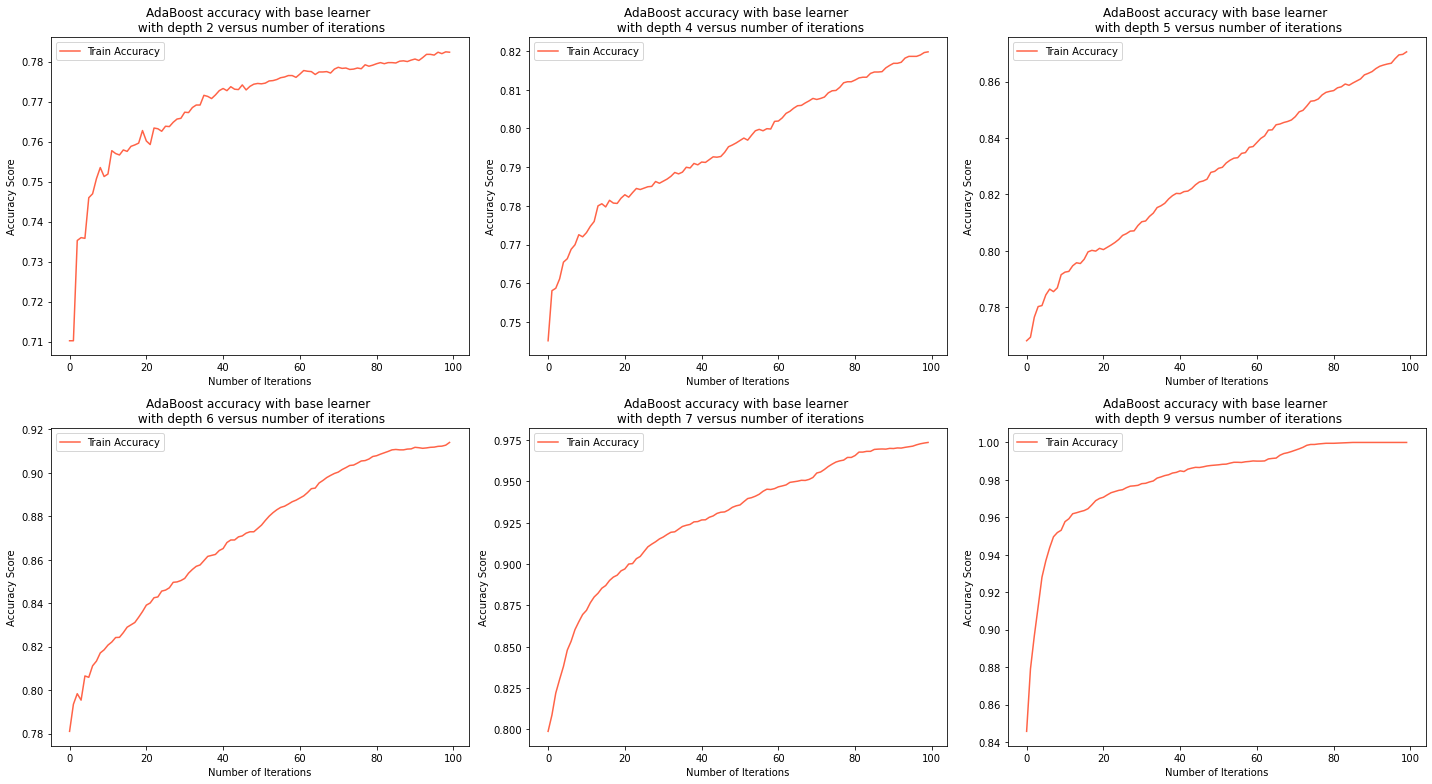

In [55]:
# extract the best 6 base tree depths for AdaBoost and plot their training iterations
def generate_adaboost_accuracy_plots(cvmeans_arr, depths, X_train_numeric_scaled_selected, X_test_numeric_scaled_selected, 
                                     y_train, y_test):
    
    # create 6 visuals in a matrix of subplots with 3 columns and 2 rows
    fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (20, 11))

    # iterate over each adaboost model and plot its accuracy versus the iterations
    for axis, d in zip(ax.ravel(), depths):
        
        # create and fit an AdaBoost classifier with the specified base tree depth 
        ada_boost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = d ), n_estimators = 75, 
                                       learning_rate = 0.04, algorithm = 'SAMME.R')
        ada_boost.fit(X_train_numeric_scaled_selected, y_train)
        ada_train_acc = list(ada_boost.staged_score(X_train_numeric_scaled_selected, y_train))
        
        # plot the iteration results
        axis.plot(range(75), ada_train_acc, label="Train Accuracy", color = 'tomato')
        axis.set_xlabel("Number of Iterations")
        axis.set_ylabel("Accuracy Score")
        axis.set_title(f"AdaBoost accuracy with base learner \n with depth {d} versus number of iterations")
        axis.legend()

    plt.tight_layout()

# extract the best 6 depths to plot
cvmeans_arr = np.array(cvmeans)
depths = np.argpartition(cvmeans_arr, 6)[-6:] + 1
generate_adaboost_accuracy_plots(cvmeans_arr, np.sort(depths), X_train_numeric_scaled_selected, X_test_numeric_scaled_selected, y_train_res, y_test)


### Create a Neural Network model with 80 features

In [56]:
# read in the feature importances that were computed above 
# we select the top 80 predictors 

feature_importance = pd.read_csv('feature_importance.csv', index_col = 0)
num_features_nn = 80

# grab our original training and test data from the census and FBI data
X_train_numeric = X_train._get_numeric_data()
X_test_numeric = X_test._get_numeric_data()

# use the top 100 predictors
X_train_nn = X_train_numeric.loc[:,feature_importance.index[:num_features_nn].to_list()]
X_test_nn = X_test_numeric.loc[:, feature_importance.index[:num_features_nn].to_list()]

# Scale the features as per before
standard_scaler = StandardScaler()
standard_scaler.fit(X_train_nn)
X_train_nn_scaled = standard_scaler.transform(X_train_nn)
X_test_nn_scaled = standard_scaler.transform(X_test_nn)

# now to balance our data we use a random over sampler.  
# for a neural network, we didn't want to use smote since this adds synthetic data
# and the neural network is generate complex decision boundaries
ros = RandomOverSampler(random_state=0)
X_train_nn_scaled_res, y_train_res = ros.fit_resample(X_train_nn_scaled, y_train)

# further split our training data into training and validation data
X_train_nn_scaled_res, X_val_nn_scaled_res, y_train_res, y_val_res = train_test_split(X_train_nn_scaled_res, 
                                                                                y_train_res, 
                                                                                test_size = 0.2, random_state = 290)
# grab the sizes of our training and validation data
train_size, val_size = y_train_res.size, y_val_res.size

In [57]:
# we need to create tensor flow datasets to feed into the neural network
# we have 3 datasets, one for training, one for validation, and one for testing
trainset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(X_train_nn_scaled_res),
    tf.data.Dataset.from_tensor_slices(y_train_res)
)).shuffle(train_size)
valset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(X_val_nn_scaled_res),
    tf.data.Dataset.from_tensor_slices(y_val_res)    
)).shuffle(val_size)
testset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(X_test_nn_scaled),
    tf.data.Dataset.from_tensor_slices(y_test)    
))

In [58]:
# Here we create a multi-layer perceprton with ReLU 
# we have 6 layers (not including dropouts)
# we have dense layers of sizes 98, 64, 32, 16, 8, 1

class NNModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.input_layer = tf.keras.layers.Dense(
            98,
            activation=activations.relu,
            input_shape=(num_features_nn, ))

        self.hidden_layers = []
        self.hidden_layers.append(tf.keras.layers.Dense(
            64,
            activation=activations.relu
        ))
        
        self.hidden_layers.append(tf.keras.layers.Dense(
            32,
            activation=activations.relu
        ))
        
        
        self.hidden_layers.append(tf.keras.layers.Dense(
            16,
            activation=activations.relu
        ))
        
        self.hidden_layers.append(tf.keras.layers.Dropout(0.3))
        
        self.hidden_layers.append(tf.keras.layers.Dense(
            8,
            activation=activations.relu
        ))
        
        self.hidden_layers.append(tf.keras.layers.Dropout(0.3))
        
        self.output_layer = tf.keras.layers.Dense(
            1,
            activation=activations.sigmoid
        )
    
    # generate our neural network
    def call(self, inputs):
        x = self.input_layer(inputs)
        for layer in self.hidden_layers:
            x = layer(x)
        output = self.output_layer(x)
        return output

In [59]:
# our function to train the neural network model
def train_model(model, trainset, valset, lr, epochs):

    model.compile(tf.keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    history = model.fit(trainset,
            epochs=epochs, 
            validation_data = valset, 
            callbacks=[tensorboard_callback])
    return history

In [60]:
batch_size = 64
epochs = 100
lr = 0.000025
model = NNModel()
history = train_model(model, 
           trainset.batch(batch_size),
           valset.batch(batch_size),
           lr,
           epochs)
            

Epoch 1/100
140/140 [==============================] - 4s 8ms/step - loss: 0.7144 - accuracy: 0.4971 - val_loss: 0.6989 - val_accuracy: 0.5020
Epoch 2/100
140/140 [==============================] - 1s 5ms/step - loss: 0.6986 - accuracy: 0.5217 - val_loss: 0.6890 - val_accuracy: 0.5748
Epoch 3/100
140/140 [==============================] - 1s 5ms/step - loss: 0.6928 - accuracy: 0.5377 - val_loss: 0.6819 - val_accuracy: 0.6013
Epoch 4/100
140/140 [==============================] - 1s 5ms/step - loss: 0.6839 - accuracy: 0.5579 - val_loss: 0.6751 - val_accuracy: 0.6295
Epoch 5/100
140/140 [==============================] - 1s 5ms/step - loss: 0.6781 - accuracy: 0.5825 - val_loss: 0.6673 - val_accuracy: 0.6417
Epoch 6/100
140/140 [==============================] - 1s 5ms/step - loss: 0.6707 - accuracy: 0.5892 - val_loss: 0.6592 - val_accuracy: 0.6560
Epoch 7/100
140/140 [==============================] - 1s 6ms/step - loss: 0.6639 - accuracy: 0.5987 - val_loss: 0.6511 - val_accuracy: 0.6556

In [61]:
testloss, testacc = model.evaluate(testset.batch(batch_size))
print(f'Neural Network Train Accuracy: {history.history["accuracy"][-1]:.4f}; Neural Network Test Accuracy: {testacc:.4f}')

31/31 [==============================] - 0s 6ms/step - loss: 0.5564 - accuracy: 0.7228
Neural Network Train Accuracy: 0.7616; Neural Network Test Accuracy: 0.7228


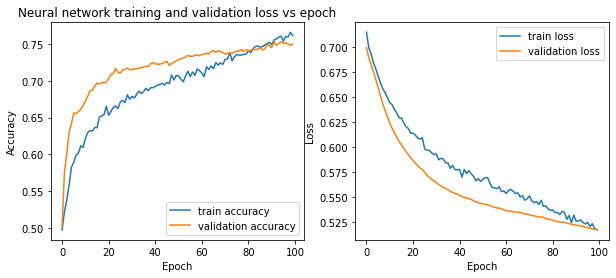

In [72]:

f, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].set_title('Neural network training and validation accuracy vs epoch')
ax[0].plot(history.history['accuracy'], label = 'train accuracy')
ax[0].plot(history.history['val_accuracy'], label = 'validation accuracy')
ax[0].legend()
ax[0].set_xlabel('Epoch');ax[0].set_ylabel('Accuracy');
ax[0].set_title('Neural network training and validation loss vs epoch')
ax[1].plot(history.history['loss'], label = 'train loss')
ax[1].plot(history.history['val_loss'], label = 'validation loss')
ax[1].legend()
ax[1].set_xlabel('Epoch');ax[1].set_ylabel('Loss');

In [69]:
# plot roc curves for all models of interest
def plot_roc_curves_group(models, X, X2, y, labels):
    
    # iterate over all models and plot their roc curve based on the input data
    for model, label in zip(models, labels):
        
        if label == 'neural network':
            yhat = model.predict(X2)
        else:
            yhat = model.predict_proba(X)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y, yhat)
        
        # plot the current model's roc curve
        x = np.arange(0, 100) / 100
        plt.plot(x,x,'--',color="gray",alpha = 0.3)
        plt.plot(fpr,tpr,label=f"{label}")
        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")
        plt.title(f"ROC Curve for Predicting Fatal Shootings with various model")
        plt.legend()
    plt.show()


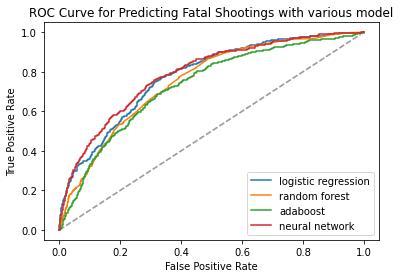

In [70]:
models = [logit, random_forest, ada_classifier, model]
model_labels = ["logistic regression", 'random forest', 'adaboost', 'neural network']
plot_roc_curves_group(models, X_test_numeric_scaled_selected, X_test_nn_scaled, y_test, model_labels)

### SHAP interpretation of Random Forest model

In [71]:
shap.initjs()

explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_train_numeric_scaled_selected)

SHAP values for "robbery rate" in class 0 (no fatal police shooting) prediction:


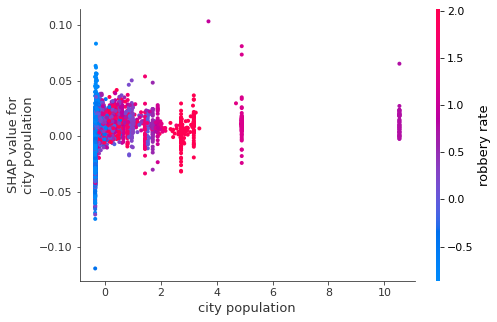

In [75]:
print('SHAP values for "robbery rate" in class 0 (no fatal police shooting) prediction:')
shap.dependence_plot(2, shap_values[1], X_train_numeric_scaled_selected, feature_names=important_columns_df.index)

SHAP values for two or more races rate in class 1 (no fatal police shooting) prediction:


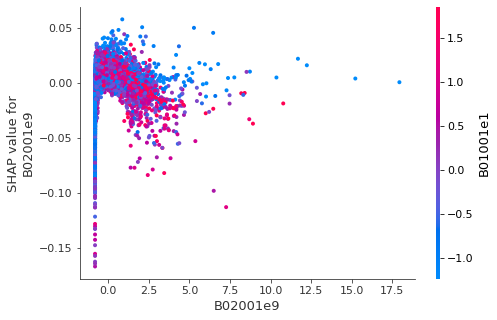

B15003e8: RACE: Two or more races: Two races including Some other race: Total population -- (Estimate)
B01001e1: SEX BY AGE: Total: Total population -- (Estimate)


In [78]:
print('SHAP values for two or more races rate in class 1 (no fatal police shooting) prediction:')
shap.dependence_plot(8, shap_values[1], X_train_numeric_scaled_selected, feature_names=important_columns_df.index)
print(f'B15003e8: {col_names["B02001e9"]}')
print(f'B01001e1: {col_names["B01001e1"]}')

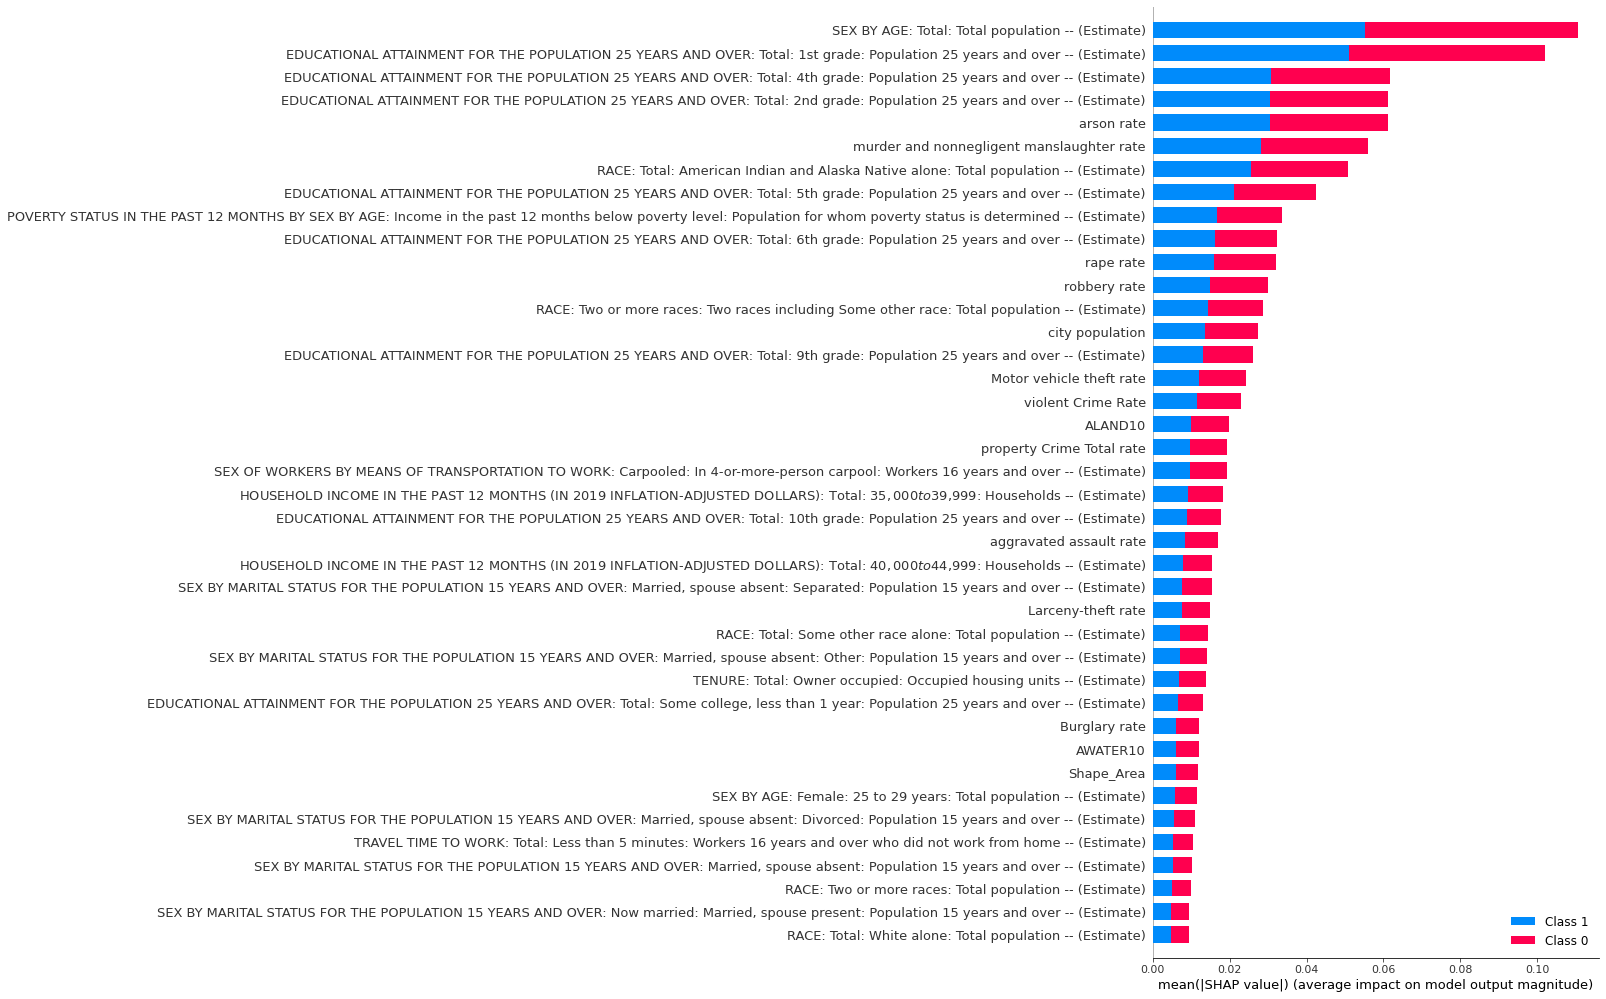

In [79]:
shap.summary_plot(shap_values, X_train_numeric_scaled_selected, feature_names=col_names[important_columns_df.index.to_list()], max_display=40)

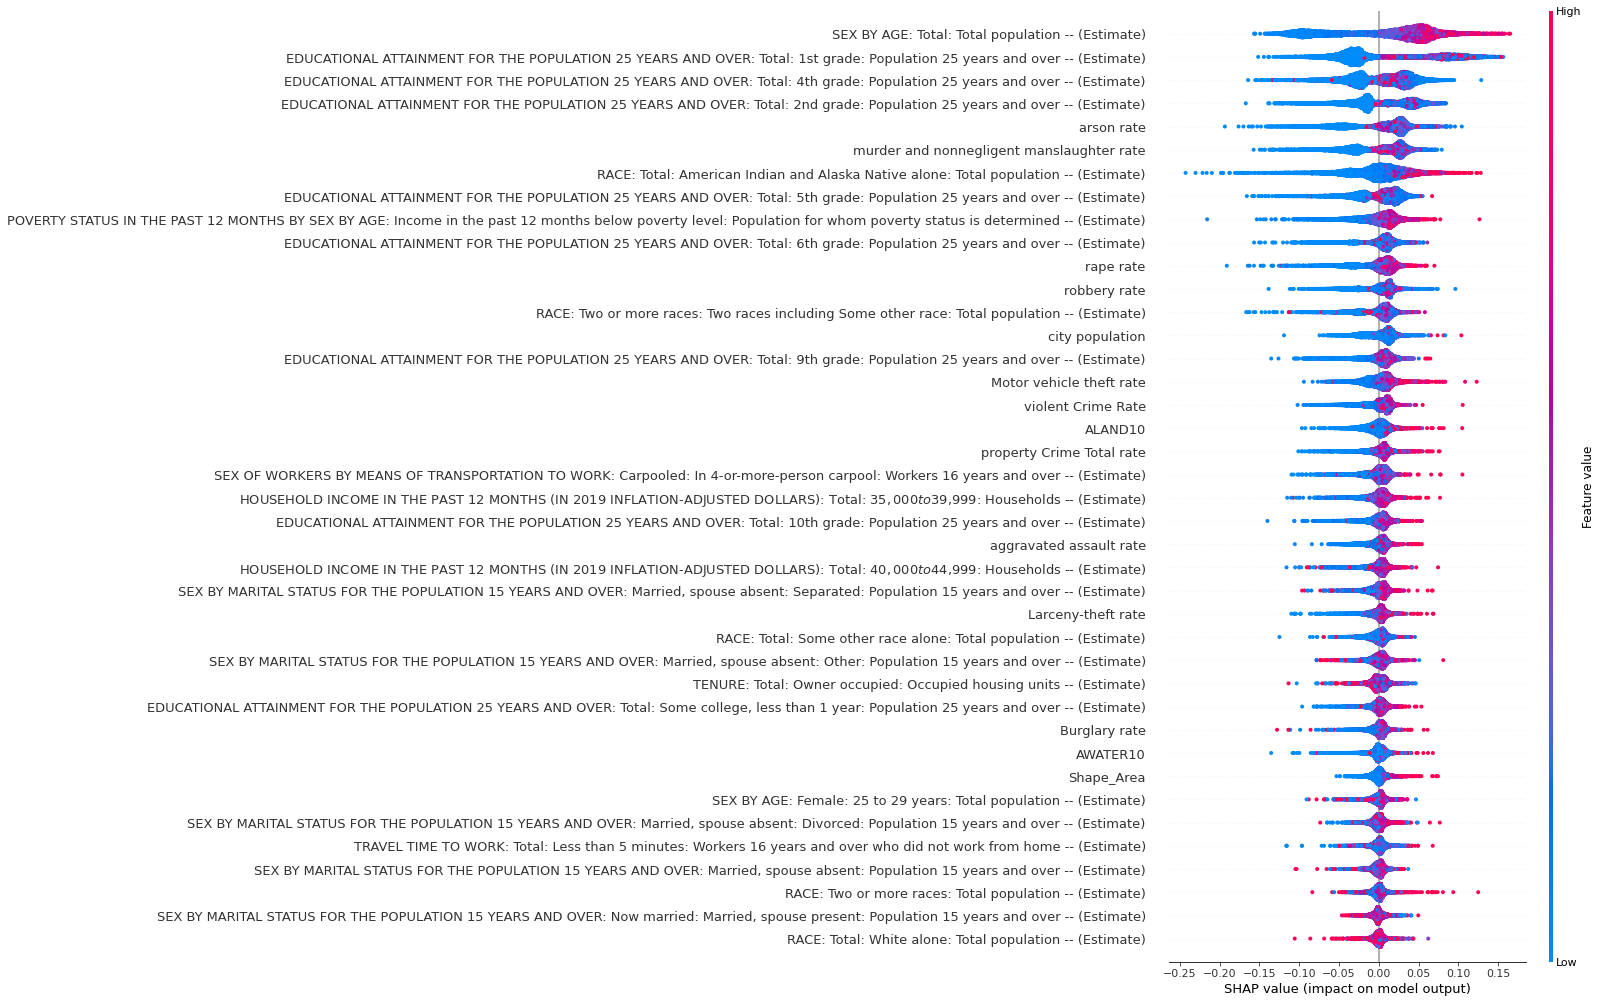

In [80]:
shap.summary_plot(shap_values[1], X_train_numeric_scaled_selected, 
                  feature_names=col_names[important_columns_df.index.to_list()], max_display=40)